# Detección de anomalías en un marco de auditoría continua

## Graficos comparativos por modelo

### Split del dataset

Split del dataset para reservar un conjunto de datos para validación posterior al entrenamiento y desarrollo de los modelos.

In [1]:
# Importación de librerías
import pandas as pd
import numpy as np
import os
import time
import joblib

# Filtro de warnings.
import warnings
warnings.filterwarnings("ignore")

# Carga del dataset.
os.chdir('..')
df = pd.read_csv('df_preprocessed.csv')

# Split del dataset para reservar un conjunto de validación.
from sklearn.model_selection import train_test_split
df_training, df_validation = train_test_split(df, test_size = 0.2, random_state = 42, shuffle = True, stratify = np.array(df['isFraud']))

### Balanceo de datos

Para el balanceo de datos, se recurre a una técnica híbrida:
- Por un lado, se submuestrean los registros de la clase mayoritaria, utilizando muestreo sin reposición.
- Por otro lado, se sobremuestrean los registros de la clase minoritaria, utilizando muestreo con reposición.
- Se recurre a un valor de k, que representa el factor de muestreo. A mayor k, mayor es la participación de casos de fraude dentro del nuevo dataset.

In [2]:
# Función para el balanceo de datos.
from sklearn.utils import resample

def balancing(X, y, k):
    # X = dataframe; y = series; k = float
    
    # Submuestreo de la clase mayoritaria.
    index_majority_downsampled = resample(X[y == 0], 
                                       replace = False,
                                       n_samples = int(len(X[y == 0]) * (1 - k)),
                                       random_state = 42).index
    
    # Sobremuestreo de la clase minoritaria.
    index_minority_oversampled = resample(X[y == 1], 
                                       replace = True,
                                       n_samples = int(len(X[y == 1]) * (1 + k)),
                                       random_state = 42).index
    
    indexes = list(index_majority_downsampled) + list(index_minority_oversampled)
    
    return indexes

### Función de entrenamiento y validación

In [3]:
# Importación de librerias.
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

# Definición de función.
def ml_train_test(data_training, data_validation, estimator, dropped_columns, scaler = None, balanced = False):
    
    # Subset de datos
    X_train = data_training.drop(labels = dropped_columns, axis = 1)
    y_train = data_training['isFraud']
    X_test = data_validation.drop(labels = dropped_columns, axis = 1)
    y_test = data_validation['isFraud']
    
    # Scaling
    if scaler == None:
        X_train = X_train
        X_test = X_test
    else:
        train_index = X_train.index
        train_columns = X_train.columns
        X_train = pd.DataFrame(scaler.fit_transform(X_train))
        X_train.index = train_index
        X_train.columns = train_columns
        
        test_index = X_test.index
        test_columns = X_test.columns
        X_test = pd.DataFrame(scaler.fit_transform(X_test))
        X_test.index = test_index
        X_test.columns = test_columns
    
    # Balanceo de datos
    if balanced == True:
        indexes = balancing(X_train, y_train, 0.8)
        X_train = X_train.loc[indexes, :]
        y_train = y_train.loc[indexes]
    else:
        X_train = X_train
        y_train = y_train
    
    # Entrenamiento del modelo.
    clf = estimator
    clf.fit(X_train, y_train)
    
    # Predicción de valores.
    y_pred = clf.predict(X_test)
    
    # Obtención de metricas.
    print('Recall: %.4f' % recall_score(y_true = y_test, y_pred = y_pred))
    print('Precision: %.4f' % precision_score(y_true = y_test, y_pred = y_pred))
    print('AUC: %.4f' % roc_auc_score(y_true = y_test, y_score = y_pred))
    print('Accuracy: %.4f' % accuracy_score(y_true = y_test, y_pred = y_pred))
    print('F1-Score: %.4f' % f1_score(y_true = y_test, y_pred = y_pred))
    
    return y_test, y_pred, clf

In [4]:
# Exportación de gráficos.
# from export import export_png
# export_png(filename = 'test', y_test = y_test, y_pred = y_pred)

### Árboles de Decisión (Decision trees)

In [5]:
%%time
# Importación de librerias.
from sklearn.tree import DecisionTreeClassifier

# Espacio de busqueda.
columns = ['isFraud', 'isFlaggedFraud']
params = {'class_weight' : None,
          'criterion' : 'entropy',
          'max_depth' : 19,
          'min_samples_leaf' : 2,
          'min_samples_split' : 2, 
          'random_state' : 42,
          'splitter' : 'best'}

columns_balanced = ['isFraud', 'isFlaggedFraud']
params_balanced = {'class_weight' : 'balanced',
                    'criterion' : 'entropy',
                    'max_depth' : 43, 
                    'min_samples_leaf' : 5, 
                    'min_samples_split' : 4, 
                    'random_state' : 42,
                    'splitter' : 'best'}

# Nombre de archivo.
filename = 'decision_tree'

# Ejecución del modelo.
print('Unbalanced: ')
y_test_unbalanced, y_pred_unbalanced, clf_unbalanced = ml_train_test(data_training = df_training, 
                                                                     data_validation = df_validation,
                                                                     estimator = DecisionTreeClassifier(**params),
                                                                     dropped_columns = columns, 
                                                                     scaler = None, 
                                                                     balanced = False)
print('\nBalanced: ')
y_test_balanced, y_pred_balanced, clf_balanced = ml_train_test(data_training = df_training, 
                                                               data_validation = df_validation, 
                                                               estimator = DecisionTreeClassifier(**params_balanced), 
                                                               dropped_columns = columns_balanced,
                                                               scaler = None,
                                                               balanced = True)

Unbalanced: 
Recall: 0.8509
Precision: 0.9143
AUC: 0.9254
Accuracy: 0.9997
F1-Score: 0.8815

Balanced: 
Recall: 0.9519
Precision: 0.6216
AUC: 0.9756
Accuracy: 0.9992
F1-Score: 0.7521
CPU times: total: 58.9 s
Wall time: 59 s


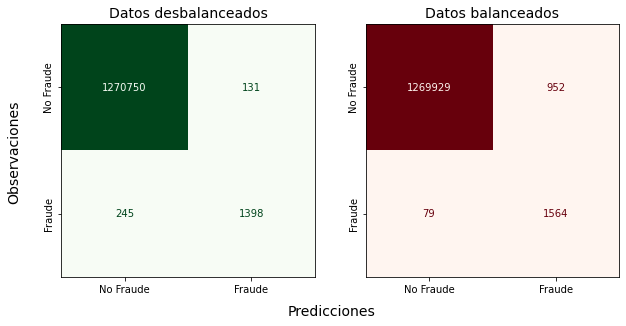

In [6]:
# Importación de librerias.
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix

# Obtención de la matriz de confusión
cm_unbalanced = confusion_matrix(y_true = y_test_unbalanced, y_pred = y_pred_unbalanced)
disp_unbalanced = ConfusionMatrixDisplay(cm_unbalanced, display_labels = ['No Fraude', 'Fraude'])

cm_balanced = confusion_matrix(y_true = y_test_balanced, y_pred = y_pred_balanced)
disp_balanced = ConfusionMatrixDisplay(cm_balanced, display_labels = ['No Fraude', 'Fraude'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,6))
disp_unbalanced.plot(ax = ax1, values_format = 'd', cmap = 'Greens') #tab20b
disp_unbalanced.im_.colorbar.remove()
disp_balanced.plot(ax = ax2, values_format = 'd', cmap = 'Reds')
disp_balanced.im_.colorbar.remove()

ax1.set_xlabel(xlabel = '', fontdict = {'fontsize' : 14})
ax1.set_ylabel(ylabel = '', fontdict = {'fontsize' : 14})
ax1.set_title('Datos desbalanceados', fontsize = 14)
ax2.set_xlabel(xlabel = '', fontdict = {'fontsize' : 14})
ax2.set_ylabel(ylabel = '', fontdict = {'fontsize' : 14})
ax2.set_title('Datos balanceados', fontsize = 14)
ax2.set_yticklabels(labels = ['No Fraude', 'Fraude'], rotation = 90, va = 'center')
ax1.set_yticklabels(labels = ['No Fraude', 'Fraude'], rotation = 90, va = 'center')
fig.text(0.5, 0.12, 'Predicciones', ha = 'center', fontdict = {'fontsize' : 14})
fig.text(0.05, 0.5, 'Observaciones', va = 'center', rotation = 'vertical', fontdict = {'fontsize' : 14})

plt.savefig('.//figures//' + filename + '_both_confusion_matrix.png')

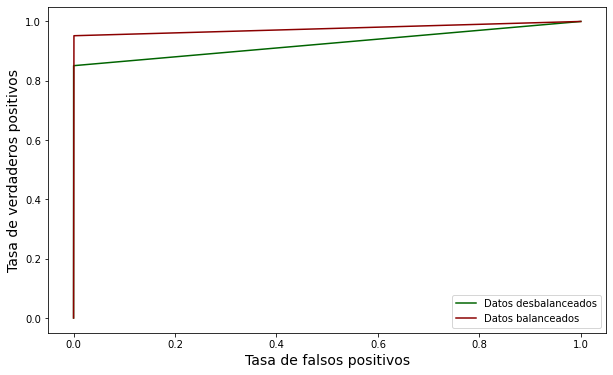

In [7]:
# Importación de librerias.
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, RocCurveDisplay

# Obtención de la curva ROC
fpr_unbalanced, tpr_unbalanced, thresholds_unbalanced = roc_curve(y_true = y_test_unbalanced, y_score = y_pred_unbalanced)
disp_unbalanced = RocCurveDisplay(fpr = fpr_unbalanced, tpr = tpr_unbalanced)

fpr_balanced, tpr_balanced, thresholds_balanced = roc_curve(y_true = y_test_balanced, y_score = y_pred_balanced)
disp_balanced = RocCurveDisplay(fpr = fpr_balanced, tpr = tpr_balanced)

fig = plt.figure(figsize = (10,6))
ax = plt.axes()
disp_unbalanced.plot(ax = ax, c = 'darkgreen')
disp_balanced.plot(ax = ax, c = 'darkred')
ax.set_xlabel(xlabel = 'Tasa de falsos positivos', fontdict = {'fontsize' : 14})
ax.set_ylabel(ylabel = 'Tasa de verdaderos positivos', fontdict = {'fontsize' : 14})
ax.legend(['Datos desbalanceados', 'Datos balanceados'])
plt.savefig('.//figures//' + filename + '_both_roc_curve.png')

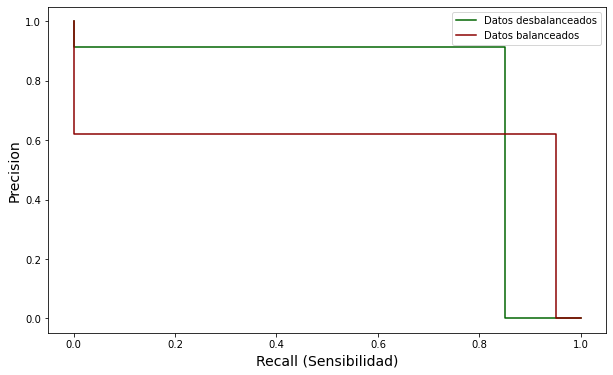

In [8]:
# Importación de librerias.
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

# Obtención de la curva Recall - Precision
prec_unbalanced, recall_unbalanced, _unbalanced = precision_recall_curve(y_true = y_test_unbalanced, probas_pred = y_pred_unbalanced)
disp_unbalanced = PrecisionRecallDisplay(precision = prec_unbalanced, recall = recall_unbalanced)

prec_balanced, recall_balanced, _balanced = precision_recall_curve(y_true = y_test_balanced, probas_pred = y_pred_balanced)
disp_balanced = PrecisionRecallDisplay(precision = prec_balanced, recall = recall_balanced)

fig = plt.figure(figsize = (10,6))
ax = plt.axes()
disp_unbalanced.plot(ax = ax, c = 'darkgreen')
disp_balanced.plot(ax = ax, c = 'darkred')
ax.set_xlabel(xlabel = 'Recall (Sensibilidad)', fontdict = {'fontsize' : 14})
ax.set_ylabel(ylabel = 'Precision', fontdict = {'fontsize' : 14})
ax.legend(['Datos desbalanceados', 'Datos balanceados'])
plt.savefig('.//figures//' + filename + '_both_precision_recall.png')

In [9]:
# Almacenamiento del modelo.
from joblib import dump, load
dump(value = clf_unbalanced, filename = './/models//' + filename + '_unbalanced.joblib')
dump(value = clf_balanced, filename = './/models//' + filename + '_balanced.joblib')

['.//models//decision_tree_balanced.joblib']

### SVM

In [9]:
%%time
# Importación de librerias.
from sklearn.svm import LinearSVC
from sklearn.preprocessing import RobustScaler

# Espacio de busqueda.
columns = ['hour', 'idOrig', 'idDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']
scaler = RobustScaler()
params = {'C': 1.0133302917779023, 
          'class_weight': 'balanced', 
          'dual': True, 
          'fit_intercept': False, 
          'intercept_scaling': 0.944325842815949, 
          'loss': 'squared_hinge', 
          'max_iter': 233, 
          'penalty': 'l2', 
          'random_state': 42, 
          'tol': 0.00010786938279906948}

columns_balanced = ['day', 'idOrig', 'idDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']
scaler_balanced = RobustScaler()
params_balanced = {'C': 1.0026895733272085, 
                  'class_weight': None, 
                  'fit_intercept': True, 
                  'intercept_scaling': 1.013090208053348, 
                  'loss': 'hinge', 
                  'max_iter': 28, 
                  'penalty': 'l2', 
                  'random_state': 42, 
                  'tol': 9.570017427461634e-05}

# Nombre de archivo.
filename = 'svm'

# Ejecución del modelo.
print('Unbalanced: ')
y_test_unbalanced, y_pred_unbalanced, clf_unbalanced = ml_train_test(data_training = df_training, 
                                                                     data_validation = df_validation,
                                                                     estimator = LinearSVC(**params),
                                                                     dropped_columns = columns, 
                                                                     scaler = scaler, 
                                                                     balanced = False)
print('\nBalanced: ')
y_test_balanced, y_pred_balanced, clf_balanced = ml_train_test(data_training = df_training, 
                                                               data_validation = df_validation, 
                                                               estimator = LinearSVC(**params_balanced), 
                                                               dropped_columns = columns_balanced,
                                                               scaler = scaler_balanced,
                                                               balanced = True)

Unbalanced: 
Recall: 0.8795
Precision: 0.1393
AUC: 0.9362
Accuracy: 0.9928
F1-Score: 0.2405

Balanced: 
Recall: 0.5338
Precision: 0.7929
AUC: 0.7668
Accuracy: 0.9992
F1-Score: 0.6381
CPU times: total: 1min 59s
Wall time: 1min 58s


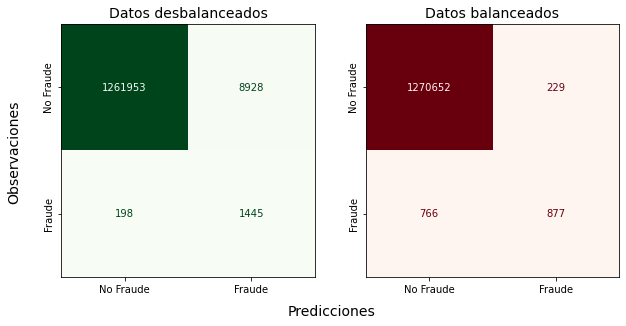

In [10]:
# Importación de librerias.
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix

# Obtención de la matriz de confusión
cm_unbalanced = confusion_matrix(y_true = y_test_unbalanced, y_pred = y_pred_unbalanced)
disp_unbalanced = ConfusionMatrixDisplay(cm_unbalanced, display_labels = ['No Fraude', 'Fraude'])

cm_balanced = confusion_matrix(y_true = y_test_balanced, y_pred = y_pred_balanced)
disp_balanced = ConfusionMatrixDisplay(cm_balanced, display_labels = ['No Fraude', 'Fraude'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,6))
disp_unbalanced.plot(ax = ax1, values_format = 'd', cmap = 'Greens') #tab20b
disp_unbalanced.im_.colorbar.remove()
disp_balanced.plot(ax = ax2, values_format = 'd', cmap = 'Reds')
disp_balanced.im_.colorbar.remove()

ax1.set_xlabel(xlabel = '', fontdict = {'fontsize' : 14})
ax1.set_ylabel(ylabel = '', fontdict = {'fontsize' : 14})
ax1.set_title('Datos desbalanceados', fontsize = 14)
ax2.set_xlabel(xlabel = '', fontdict = {'fontsize' : 14})
ax2.set_ylabel(ylabel = '', fontdict = {'fontsize' : 14})
ax2.set_title('Datos balanceados', fontsize = 14)
ax2.set_yticklabels(labels = ['No Fraude', 'Fraude'], rotation = 90, va = 'center')
ax1.set_yticklabels(labels = ['No Fraude', 'Fraude'], rotation = 90, va = 'center')
fig.text(0.5, 0.12, 'Predicciones', ha = 'center', fontdict = {'fontsize' : 14})
fig.text(0.05, 0.5, 'Observaciones', va = 'center', rotation = 'vertical', fontdict = {'fontsize' : 14})

plt.savefig('.//figures//' + filename + '_both_confusion_matrix.png')

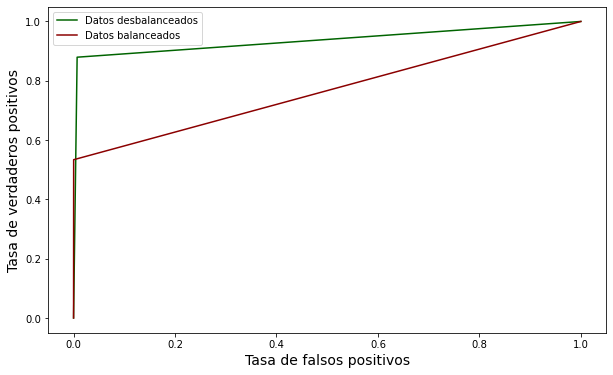

In [11]:
# Importación de librerias.
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, RocCurveDisplay

# Obtención de la curva ROC
fpr_unbalanced, tpr_unbalanced, thresholds_unbalanced = roc_curve(y_true = y_test_unbalanced, y_score = y_pred_unbalanced)
disp_unbalanced = RocCurveDisplay(fpr = fpr_unbalanced, tpr = tpr_unbalanced)

fpr_balanced, tpr_balanced, thresholds_balanced = roc_curve(y_true = y_test_balanced, y_score = y_pred_balanced)
disp_balanced = RocCurveDisplay(fpr = fpr_balanced, tpr = tpr_balanced)

fig = plt.figure(figsize = (10,6))
ax = plt.axes()
disp_unbalanced.plot(ax = ax, c = 'darkgreen')
disp_balanced.plot(ax = ax, c = 'darkred')
ax.set_xlabel(xlabel = 'Tasa de falsos positivos', fontdict = {'fontsize' : 14})
ax.set_ylabel(ylabel = 'Tasa de verdaderos positivos', fontdict = {'fontsize' : 14})
ax.legend(['Datos desbalanceados', 'Datos balanceados'])
plt.savefig('.//figures//' + filename + '_both_roc_curve.png')

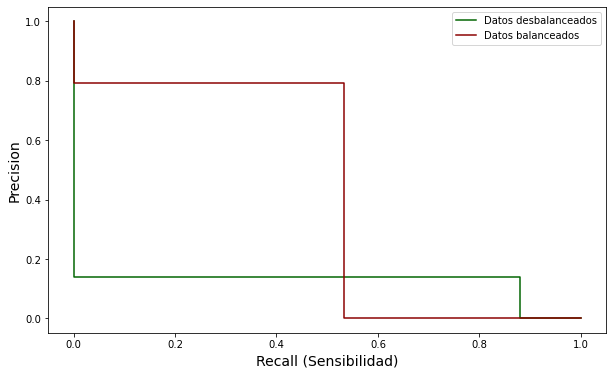

In [12]:
# Importación de librerias.
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

# Obtención de la curva Recall - Precision
prec_unbalanced, recall_unbalanced, _unbalanced = precision_recall_curve(y_true = y_test_unbalanced, probas_pred = y_pred_unbalanced)
disp_unbalanced = PrecisionRecallDisplay(precision = prec_unbalanced, recall = recall_unbalanced)

prec_balanced, recall_balanced, _balanced = precision_recall_curve(y_true = y_test_balanced, probas_pred = y_pred_balanced)
disp_balanced = PrecisionRecallDisplay(precision = prec_balanced, recall = recall_balanced)

fig = plt.figure(figsize = (10,6))
ax = plt.axes()
disp_unbalanced.plot(ax = ax, c = 'darkgreen')
disp_balanced.plot(ax = ax, c = 'darkred')
ax.set_xlabel(xlabel = 'Recall (Sensibilidad)', fontdict = {'fontsize' : 14})
ax.set_ylabel(ylabel = 'Precision', fontdict = {'fontsize' : 14})
ax.legend(['Datos desbalanceados', 'Datos balanceados'])
plt.savefig('.//figures//' + filename + '_both_precision_recall.png')

In [13]:
# Almacenamiento del modelo.
from joblib import dump, load
dump(value = clf_unbalanced, filename = './/models//' + filename + '_unbalanced.joblib')
dump(value = clf_balanced, filename = './/models//' + filename + '_balanced.joblib')

['.//models//svm_balanced.joblib']

### Redes neuronales

In [4]:
%%time
# Importación de librerias.
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import RobustScaler

# Espacio de busqueda.
columns = ['isFraud', 'isFlaggedFraud', 'day', 'hour', 'idOrig', 'idDest']
scaler = RobustScaler()
params = {'activation': 'tanh', 
          'alpha': 0.0001285548950868371, 
          'hidden_layer_sizes': (3, 3, 6), 
          'random_state': 42, 
          'solver': 'lbfgs'}

columns_balanced = ['isFraud', 'isFlaggedFraud', 'idOrig', 'idDest', 'oldbalanceDest', 'newbalanceDest']
scaler_balanced = RobustScaler()
params_balanced = {'activation': 'logistic',
                   'alpha': 9.882145575443431e-05,
                   'hidden_layer_sizes': (1, 5, 1),
                   'random_state': 42,
                   'solver': 'lbfgs'}

# Nombre de archivo.
filename = 'neural_network'

# Ejecución del modelo.
print('Unbalanced: ')
y_test_unbalanced, y_pred_unbalanced, clf_unbalanced = ml_train_test(data_training = df_training, 
                                                                     data_validation = df_validation,
                                                                     estimator = MLPClassifier(**params),
                                                                     dropped_columns = columns, 
                                                                     scaler = scaler, 
                                                                     balanced = False)
print('\nBalanced: ')
y_test_balanced, y_pred_balanced, clf_balanced = ml_train_test(data_training = df_training, 
                                                               data_validation = df_validation, 
                                                               estimator = MLPClassifier(**params_balanced), 
                                                               dropped_columns = columns_balanced,
                                                               scaler = scaler_balanced,
                                                               balanced = True)

Unbalanced: 
Recall: 0.9787
Precision: 0.8463
AUC: 0.9892
Accuracy: 0.9997
F1-Score: 0.9077

Balanced: 
Recall: 0.9805
Precision: 0.7553
AUC: 0.9901
Accuracy: 0.9996
F1-Score: 0.8533
CPU times: total: 35min 35s
Wall time: 11min 12s


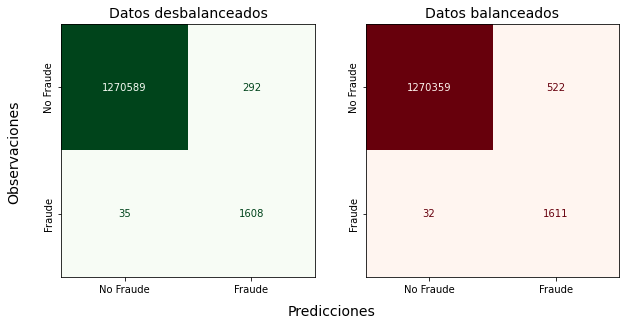

In [15]:
# Importación de librerias.
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix

# Obtención de la matriz de confusión
cm_unbalanced = confusion_matrix(y_true = y_test_unbalanced, y_pred = y_pred_unbalanced)
disp_unbalanced = ConfusionMatrixDisplay(cm_unbalanced, display_labels = ['No Fraude', 'Fraude'])

cm_balanced = confusion_matrix(y_true = y_test_balanced, y_pred = y_pred_balanced)
disp_balanced = ConfusionMatrixDisplay(cm_balanced, display_labels = ['No Fraude', 'Fraude'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,6))
disp_unbalanced.plot(ax = ax1, values_format = 'd', cmap = 'Greens') #tab20b
disp_unbalanced.im_.colorbar.remove()
disp_balanced.plot(ax = ax2, values_format = 'd', cmap = 'Reds')
disp_balanced.im_.colorbar.remove()

ax1.set_xlabel(xlabel = '', fontdict = {'fontsize' : 14})
ax1.set_ylabel(ylabel = '', fontdict = {'fontsize' : 14})
ax1.set_title('Datos desbalanceados', fontsize = 14)
ax2.set_xlabel(xlabel = '', fontdict = {'fontsize' : 14})
ax2.set_ylabel(ylabel = '', fontdict = {'fontsize' : 14})
ax2.set_title('Datos balanceados', fontsize = 14)
ax2.set_yticklabels(labels = ['No Fraude', 'Fraude'], rotation = 90, va = 'center')
ax1.set_yticklabels(labels = ['No Fraude', 'Fraude'], rotation = 90, va = 'center')
fig.text(0.5, 0.12, 'Predicciones', ha = 'center', fontdict = {'fontsize' : 14})
fig.text(0.05, 0.5, 'Observaciones', va = 'center', rotation = 'vertical', fontdict = {'fontsize' : 14})

plt.savefig('.//figures//' + filename + '_both_confusion_matrix.png')

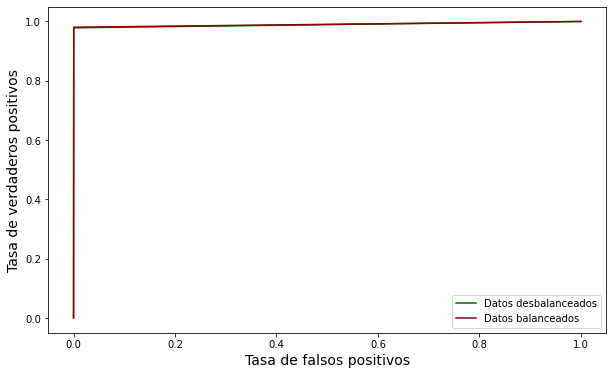

In [16]:
# Importación de librerias.
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, RocCurveDisplay

# Obtención de la curva ROC
fpr_unbalanced, tpr_unbalanced, thresholds_unbalanced = roc_curve(y_true = y_test_unbalanced, y_score = y_pred_unbalanced)
disp_unbalanced = RocCurveDisplay(fpr = fpr_unbalanced, tpr = tpr_unbalanced)

fpr_balanced, tpr_balanced, thresholds_balanced = roc_curve(y_true = y_test_balanced, y_score = y_pred_balanced)
disp_balanced = RocCurveDisplay(fpr = fpr_balanced, tpr = tpr_balanced)

fig = plt.figure(figsize = (10,6))
ax = plt.axes()
disp_unbalanced.plot(ax = ax, c = 'darkgreen')
disp_balanced.plot(ax = ax, c = 'darkred')
ax.set_xlabel(xlabel = 'Tasa de falsos positivos', fontdict = {'fontsize' : 14})
ax.set_ylabel(ylabel = 'Tasa de verdaderos positivos', fontdict = {'fontsize' : 14})
ax.legend(['Datos desbalanceados', 'Datos balanceados'])
plt.savefig('.//figures//' + filename + '_both_roc_curve.png')

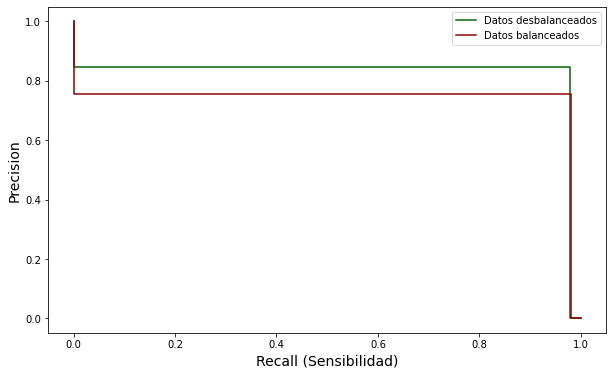

In [17]:
# Importación de librerias.
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

# Obtención de la curva Recall - Precision
prec_unbalanced, recall_unbalanced, _unbalanced = precision_recall_curve(y_true = y_test_unbalanced, probas_pred = y_pred_unbalanced)
disp_unbalanced = PrecisionRecallDisplay(precision = prec_unbalanced, recall = recall_unbalanced)

prec_balanced, recall_balanced, _balanced = precision_recall_curve(y_true = y_test_balanced, probas_pred = y_pred_balanced)
disp_balanced = PrecisionRecallDisplay(precision = prec_balanced, recall = recall_balanced)

fig = plt.figure(figsize = (10,6))
ax = plt.axes()
disp_unbalanced.plot(ax = ax, c = 'darkgreen')
disp_balanced.plot(ax = ax, c = 'darkred')
ax.set_xlabel(xlabel = 'Recall (Sensibilidad)', fontdict = {'fontsize' : 14})
ax.set_ylabel(ylabel = 'Precision', fontdict = {'fontsize' : 14})
ax.legend(['Datos desbalanceados', 'Datos balanceados'])
plt.savefig('.//figures//' + filename + '_both_precision_recall.png')

In [18]:
# Almacenamiento del modelo.
from joblib import dump, load
dump(value = clf_unbalanced, filename = './/models//' + filename + '_unbalanced.joblib')
dump(value = clf_balanced, filename = './/models//' + filename + '_balanced.joblib')

['.//models//neural_network_balanced.joblib']

### Random Forests

In [19]:
%%time
# Importación de librerias.
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler

# Espacio de busqueda.
columns = ['isFraud', 'isFlaggedFraud']
scaler = None
params = {'n_estimators' : 74,
          'max_depth' : 352,
          'min_samples_leaf' : 4,
          'min_samples_split' : 4,              
          'class_weight' : 'balanced',
          'criterion' : 'entropy',
          'max_features' : 0.9291134341710399,
          'max_samples' : 0.8461053136089318,
          'random_state' : 42,
          'ccp_alpha' : 0.0
         }

columns_balanced = ['isFraud', 'isFlaggedFraud']
scaler_balanced = None
params_balanced = {'class_weight': 'balanced',
                   'criterion': 'entropy', 
                   'max_depth': 26, 
                   'max_features': 0.8762318649368235, 
                   'max_samples': 0.8370855027715005, 
                   'min_samples_leaf': 3, 
                   'min_samples_split': 3, 
                   'n_estimators': 23, 
                   'random_state': 42}

# Nombre de archivo.
filename = 'rf'

# Ejecución del modelo.
print('Unbalanced: ')
y_test_unbalanced, y_pred_unbalanced, clf_unbalanced = ml_train_test(data_training = df_training, 
                                                                     data_validation = df_validation,
                                                                     estimator = RandomForestClassifier(**params),
                                                                     dropped_columns = columns, 
                                                                     scaler = scaler, 
                                                                     balanced = False)
print('\nBalanced: ')
y_test_balanced, y_pred_balanced, clf_balanced = ml_train_test(data_training = df_training, 
                                                               data_validation = df_validation, 
                                                               estimator = RandomForestClassifier(**params_balanced), 
                                                               dropped_columns = columns_balanced,
                                                               scaler = scaler_balanced,
                                                               balanced = True)

Unbalanced: 
Recall: 0.8996
Precision: 0.9152
AUC: 0.9497
Accuracy: 0.9998
F1-Score: 0.9073

Balanced: 
Recall: 0.9507
Precision: 0.7385
AUC: 0.9751
Accuracy: 0.9995
F1-Score: 0.8313
CPU times: total: 34min 37s
Wall time: 34min 48s


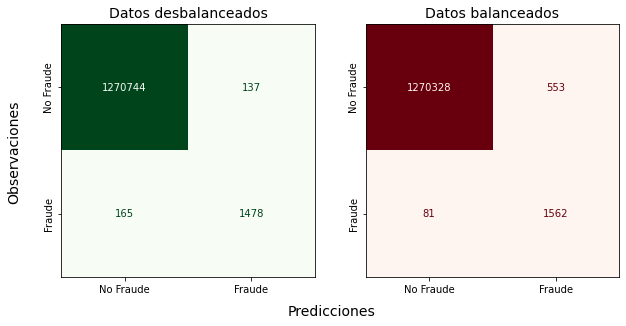

In [20]:
# Importación de librerias.
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix

# Obtención de la matriz de confusión
cm_unbalanced = confusion_matrix(y_true = y_test_unbalanced, y_pred = y_pred_unbalanced)
disp_unbalanced = ConfusionMatrixDisplay(cm_unbalanced, display_labels = ['No Fraude', 'Fraude'])

cm_balanced = confusion_matrix(y_true = y_test_balanced, y_pred = y_pred_balanced)
disp_balanced = ConfusionMatrixDisplay(cm_balanced, display_labels = ['No Fraude', 'Fraude'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,6))
disp_unbalanced.plot(ax = ax1, values_format = 'd', cmap = 'Greens') #tab20b
disp_unbalanced.im_.colorbar.remove()
disp_balanced.plot(ax = ax2, values_format = 'd', cmap = 'Reds')
disp_balanced.im_.colorbar.remove()

ax1.set_xlabel(xlabel = '', fontdict = {'fontsize' : 14})
ax1.set_ylabel(ylabel = '', fontdict = {'fontsize' : 14})
ax1.set_title('Datos desbalanceados', fontsize = 14)
ax2.set_xlabel(xlabel = '', fontdict = {'fontsize' : 14})
ax2.set_ylabel(ylabel = '', fontdict = {'fontsize' : 14})
ax2.set_title('Datos balanceados', fontsize = 14)
ax2.set_yticklabels(labels = ['No Fraude', 'Fraude'], rotation = 90, va = 'center')
ax1.set_yticklabels(labels = ['No Fraude', 'Fraude'], rotation = 90, va = 'center')
fig.text(0.5, 0.12, 'Predicciones', ha = 'center', fontdict = {'fontsize' : 14})
fig.text(0.05, 0.5, 'Observaciones', va = 'center', rotation = 'vertical', fontdict = {'fontsize' : 14})

plt.savefig('.//figures//' + filename + '_both_confusion_matrix.png')

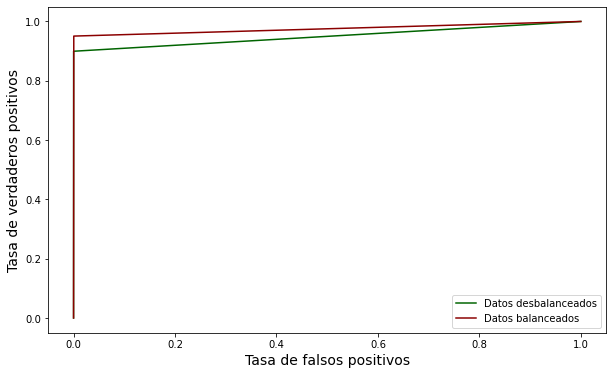

In [21]:
# Importación de librerias.
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, RocCurveDisplay

# Obtención de la curva ROC
fpr_unbalanced, tpr_unbalanced, thresholds_unbalanced = roc_curve(y_true = y_test_unbalanced, y_score = y_pred_unbalanced)
disp_unbalanced = RocCurveDisplay(fpr = fpr_unbalanced, tpr = tpr_unbalanced)

fpr_balanced, tpr_balanced, thresholds_balanced = roc_curve(y_true = y_test_balanced, y_score = y_pred_balanced)
disp_balanced = RocCurveDisplay(fpr = fpr_balanced, tpr = tpr_balanced)

fig = plt.figure(figsize = (10,6))
ax = plt.axes()
disp_unbalanced.plot(ax = ax, c = 'darkgreen')
disp_balanced.plot(ax = ax, c = 'darkred')
ax.set_xlabel(xlabel = 'Tasa de falsos positivos', fontdict = {'fontsize' : 14})
ax.set_ylabel(ylabel = 'Tasa de verdaderos positivos', fontdict = {'fontsize' : 14})
ax.legend(['Datos desbalanceados', 'Datos balanceados'])
plt.savefig('.//figures//' + filename + '_both_roc_curve.png')

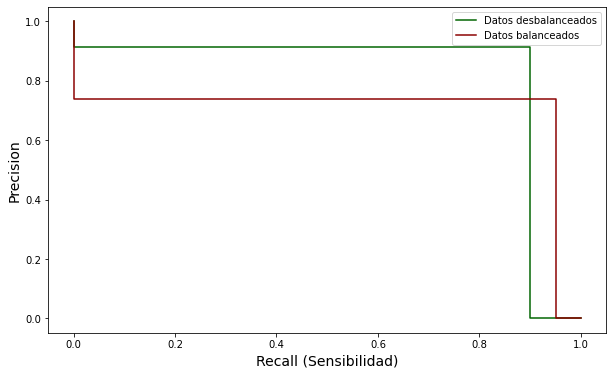

In [22]:
# Importación de librerias.
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

# Obtención de la curva Recall - Precision
prec_unbalanced, recall_unbalanced, _unbalanced = precision_recall_curve(y_true = y_test_unbalanced, probas_pred = y_pred_unbalanced)
disp_unbalanced = PrecisionRecallDisplay(precision = prec_unbalanced, recall = recall_unbalanced)

prec_balanced, recall_balanced, _balanced = precision_recall_curve(y_true = y_test_balanced, probas_pred = y_pred_balanced)
disp_balanced = PrecisionRecallDisplay(precision = prec_balanced, recall = recall_balanced)

fig = plt.figure(figsize = (10,6))
ax = plt.axes()
disp_unbalanced.plot(ax = ax, c = 'darkgreen')
disp_balanced.plot(ax = ax, c = 'darkred')
ax.set_xlabel(xlabel = 'Recall (Sensibilidad)', fontdict = {'fontsize' : 14})
ax.set_ylabel(ylabel = 'Precision', fontdict = {'fontsize' : 14})
ax.legend(['Datos desbalanceados', 'Datos balanceados'])
plt.savefig('.//figures//' + filename + '_both_precision_recall.png')

In [23]:
# Almacenamiento del modelo.
from joblib import dump, load
dump(value = clf_unbalanced, filename = './/models//' + filename + '_unbalanced.joblib')
dump(value = clf_balanced, filename = './/models//' + filename + '_balanced.joblib')

['.//models//rf_balanced.joblib']

### Ensamble SVM

In [24]:
%%time
# Importación de librerias.
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import RobustScaler

# Espacio de busqueda. Datos desbalanceados.
columns = ['isFraud', 'isFlaggedFraud', 'day', 'hour', 'idOrig', 'idDest']
scaler = RobustScaler()
linear = LinearSVC(random_state = 42, C = 1.2912110784758317, loss = 'squared_hinge', penalty = 'l2', class_weight = None, 
                   dual = True, fit_intercept = False, intercept_scaling = 1.0058483479571696, max_iter = 28, tol = 9.320556357088724e-05)
params = {'base_estimator' : linear, 'n_jobs' : -1, 'random_state' : 42, 'n_estimators' : 20, 'max_features' : 0.936884412160947, 'max_samples' : 0.8789890119261643}

# Espacio de busqueda. Datos balanceados.
columns_balanced = ['isFraud', 'isFlaggedFraud', 'day', 'hour', 'idOrig', 'idDest']
scaler_balanced = RobustScaler()
linear_balanced = LinearSVC(**{'C': 1.0026895733272085, 'class_weight': None, 'fit_intercept': True, 'intercept_scaling': 1.013090208053348, 'loss': 'hinge', 
                               'max_iter': 28, 'penalty': 'l2', 'random_state': 42, 'tol': 9.570017427461634e-05})
params_balanced = {'base_estimator' : linear_balanced, 'n_jobs' : -1, 'random_state' : 42, 'max_features' : 0.9531431016263201, 'max_samples' : 0.8283494923707083, 'n_estimators': 20}

# Nombre de archivo.
filename = 'bagging_svm'

# Ejecución del modelo.
print('Unbalanced: ')
y_test_unbalanced, y_pred_unbalanced, clf_unbalanced = ml_train_test(data_training = df_training, 
                                                                     data_validation = df_validation,
                                                                     estimator = BaggingClassifier(**params),
                                                                     dropped_columns = columns, 
                                                                     scaler = scaler, 
                                                                     balanced = False)
print('\nBalanced: ')
y_test_balanced, y_pred_balanced, clf_balanced = ml_train_test(data_training = df_training, 
                                                               data_validation = df_validation, 
                                                               estimator = BaggingClassifier(**params_balanced), 
                                                               dropped_columns = columns_balanced,
                                                               scaler = scaler_balanced,
                                                               balanced = True)

Unbalanced: 
Recall: 0.3767
Precision: 0.9872
AUC: 0.6884
Accuracy: 0.9992
F1-Score: 0.5454

Balanced: 
Recall: 0.5666
Precision: 0.7950
AUC: 0.7832
Accuracy: 0.9993
F1-Score: 0.6617
CPU times: total: 10 s
Wall time: 2min 37s


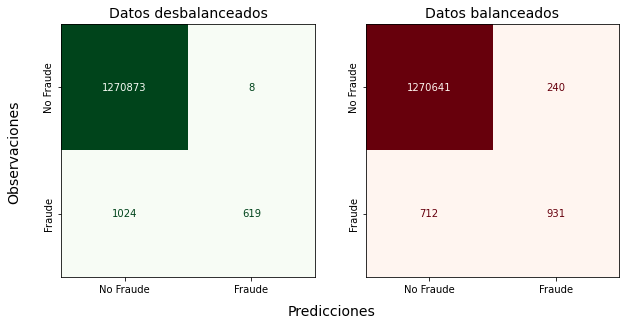

In [25]:
# Importación de librerias.
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix

# Obtención de la matriz de confusión
cm_unbalanced = confusion_matrix(y_true = y_test_unbalanced, y_pred = y_pred_unbalanced)
disp_unbalanced = ConfusionMatrixDisplay(cm_unbalanced, display_labels = ['No Fraude', 'Fraude'])

cm_balanced = confusion_matrix(y_true = y_test_balanced, y_pred = y_pred_balanced)
disp_balanced = ConfusionMatrixDisplay(cm_balanced, display_labels = ['No Fraude', 'Fraude'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,6))
disp_unbalanced.plot(ax = ax1, values_format = 'd', cmap = 'Greens') #tab20b
disp_unbalanced.im_.colorbar.remove()
disp_balanced.plot(ax = ax2, values_format = 'd', cmap = 'Reds')
disp_balanced.im_.colorbar.remove()

ax1.set_xlabel(xlabel = '', fontdict = {'fontsize' : 14})
ax1.set_ylabel(ylabel = '', fontdict = {'fontsize' : 14})
ax1.set_title('Datos desbalanceados', fontsize = 14)
ax2.set_xlabel(xlabel = '', fontdict = {'fontsize' : 14})
ax2.set_ylabel(ylabel = '', fontdict = {'fontsize' : 14})
ax2.set_title('Datos balanceados', fontsize = 14)
ax2.set_yticklabels(labels = ['No Fraude', 'Fraude'], rotation = 90, va = 'center')
ax1.set_yticklabels(labels = ['No Fraude', 'Fraude'], rotation = 90, va = 'center')
fig.text(0.5, 0.12, 'Predicciones', ha = 'center', fontdict = {'fontsize' : 14})
fig.text(0.05, 0.5, 'Observaciones', va = 'center', rotation = 'vertical', fontdict = {'fontsize' : 14})

plt.savefig('.//figures//' + filename + '_both_confusion_matrix.png')

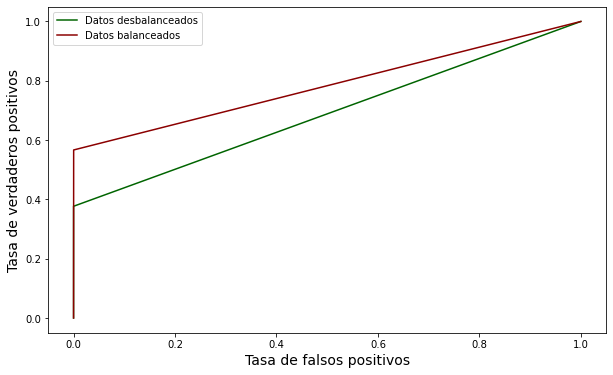

In [26]:
# Importación de librerias.
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, RocCurveDisplay

# Obtención de la curva ROC
fpr_unbalanced, tpr_unbalanced, thresholds_unbalanced = roc_curve(y_true = y_test_unbalanced, y_score = y_pred_unbalanced)
disp_unbalanced = RocCurveDisplay(fpr = fpr_unbalanced, tpr = tpr_unbalanced)

fpr_balanced, tpr_balanced, thresholds_balanced = roc_curve(y_true = y_test_balanced, y_score = y_pred_balanced)
disp_balanced = RocCurveDisplay(fpr = fpr_balanced, tpr = tpr_balanced)

fig = plt.figure(figsize = (10,6))
ax = plt.axes()
disp_unbalanced.plot(ax = ax, c = 'darkgreen')
disp_balanced.plot(ax = ax, c = 'darkred')
ax.set_xlabel(xlabel = 'Tasa de falsos positivos', fontdict = {'fontsize' : 14})
ax.set_ylabel(ylabel = 'Tasa de verdaderos positivos', fontdict = {'fontsize' : 14})
ax.legend(['Datos desbalanceados', 'Datos balanceados'])
plt.savefig('.//figures//' + filename + '_both_roc_curve.png')

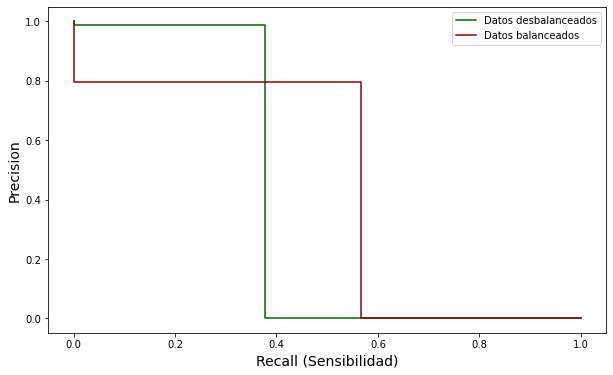

In [27]:
# Importación de librerias.
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

# Obtención de la curva Recall - Precision
prec_unbalanced, recall_unbalanced, _unbalanced = precision_recall_curve(y_true = y_test_unbalanced, probas_pred = y_pred_unbalanced)
disp_unbalanced = PrecisionRecallDisplay(precision = prec_unbalanced, recall = recall_unbalanced)

prec_balanced, recall_balanced, _balanced = precision_recall_curve(y_true = y_test_balanced, probas_pred = y_pred_balanced)
disp_balanced = PrecisionRecallDisplay(precision = prec_balanced, recall = recall_balanced)

fig = plt.figure(figsize = (10,6))
ax = plt.axes()
disp_unbalanced.plot(ax = ax, c = 'darkgreen')
disp_balanced.plot(ax = ax, c = 'darkred')
ax.set_xlabel(xlabel = 'Recall (Sensibilidad)', fontdict = {'fontsize' : 14})
ax.set_ylabel(ylabel = 'Precision', fontdict = {'fontsize' : 14})
ax.legend(['Datos desbalanceados', 'Datos balanceados'])
plt.savefig('.//figures//' + filename + '_both_precision_recall.png')

In [28]:
# Almacenamiento del modelo.
from joblib import dump, load
dump(value = clf_unbalanced, filename = './/models//' + filename + '_unbalanced.joblib')
dump(value = clf_balanced, filename = './/models//' + filename + '_balanced.joblib')

['.//models//bagging_svm_balanced.joblib']

### Ensamble Redes Neuronales

In [29]:
%%time
# Importación de librerias.
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import RobustScaler

# Espacio de busqueda.
columns = ['isFraud', 'isFlaggedFraud', 'day', 'hour', 'idOrig', 'idDest']
scaler = RobustScaler()
mlp = MLPClassifier(**{'activation': 'tanh', 'alpha': 0.0001285548950868371, 'hidden_layer_sizes': (3, 3, 6), 'random_state': 42, 'solver': 'lbfgs'})
params = {'base_estimator' : mlp, 'n_jobs' : -1, 'random_state' : 42, 'max_features': 0.9035559312236554, 'max_samples': 0.8822611141001702, 'n_estimators': 1}

columns_balanced = ['isFraud', 'isFlaggedFraud', 'idOrig', 'idDest', 'oldbalanceDest', 'newbalanceDest']
scaler_balanced = RobustScaler()
mlp_balanced = MLPClassifier(activation = 'tanh', alpha = 9.882145575443431e-05, hidden_layer_sizes = (1, 5, 1), random_state = 42, solver = 'lbfgs')
params_balanced = {'base_estimator' : mlp_balanced, 'n_jobs' : -1, 'random_state' : 42,
                   'max_features': 0.9218208298176639, 'max_samples': 0.9460079200724107, 'n_estimators': 5}

# Nombre de archivo.
filename = 'bagging_nn'

# Ejecución del modelo.
print('Unbalanced: ')
y_test_unbalanced, y_pred_unbalanced, clf_unbalanced = ml_train_test(data_training = df_training, 
                                                                     data_validation = df_validation,
                                                                     estimator = BaggingClassifier(**params),
                                                                     dropped_columns = columns, 
                                                                     scaler = scaler, 
                                                                     balanced = False)
print('\nBalanced: ')
y_test_balanced, y_pred_balanced, clf_balanced = ml_train_test(data_training = df_training, 
                                                               data_validation = df_validation, 
                                                               estimator = BaggingClassifier(**params_balanced), 
                                                               dropped_columns = columns_balanced,
                                                               scaler = scaler_balanced,
                                                               balanced = True)

Unbalanced: 
Recall: 0.9744
Precision: 0.8223
AUC: 0.9871
Accuracy: 0.9997
F1-Score: 0.8919

Balanced: 
Recall: 0.9805
Precision: 0.8369
AUC: 0.9901
Accuracy: 0.9997
F1-Score: 0.9030
CPU times: total: 17min 49s
Wall time: 7min 29s


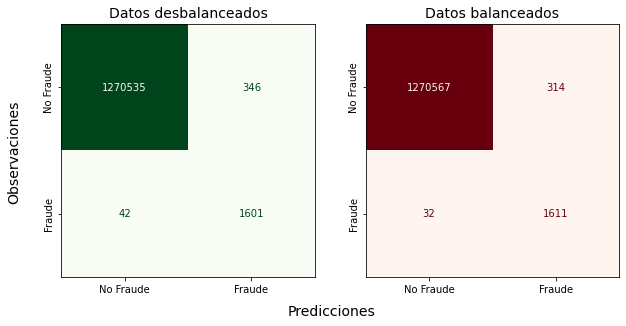

In [30]:
# Importación de librerias.
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix

# Obtención de la matriz de confusión
cm_unbalanced = confusion_matrix(y_true = y_test_unbalanced, y_pred = y_pred_unbalanced)
disp_unbalanced = ConfusionMatrixDisplay(cm_unbalanced, display_labels = ['No Fraude', 'Fraude'])

cm_balanced = confusion_matrix(y_true = y_test_balanced, y_pred = y_pred_balanced)
disp_balanced = ConfusionMatrixDisplay(cm_balanced, display_labels = ['No Fraude', 'Fraude'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,6))
disp_unbalanced.plot(ax = ax1, values_format = 'd', cmap = 'Greens') #tab20b
disp_unbalanced.im_.colorbar.remove()
disp_balanced.plot(ax = ax2, values_format = 'd', cmap = 'Reds')
disp_balanced.im_.colorbar.remove()

ax1.set_xlabel(xlabel = '', fontdict = {'fontsize' : 14})
ax1.set_ylabel(ylabel = '', fontdict = {'fontsize' : 14})
ax1.set_title('Datos desbalanceados', fontsize = 14)
ax2.set_xlabel(xlabel = '', fontdict = {'fontsize' : 14})
ax2.set_ylabel(ylabel = '', fontdict = {'fontsize' : 14})
ax2.set_title('Datos balanceados', fontsize = 14)
ax2.set_yticklabels(labels = ['No Fraude', 'Fraude'], rotation = 90, va = 'center')
ax1.set_yticklabels(labels = ['No Fraude', 'Fraude'], rotation = 90, va = 'center')
fig.text(0.5, 0.12, 'Predicciones', ha = 'center', fontdict = {'fontsize' : 14})
fig.text(0.05, 0.5, 'Observaciones', va = 'center', rotation = 'vertical', fontdict = {'fontsize' : 14})

plt.savefig('.//figures//' + filename + '_both_confusion_matrix.png')

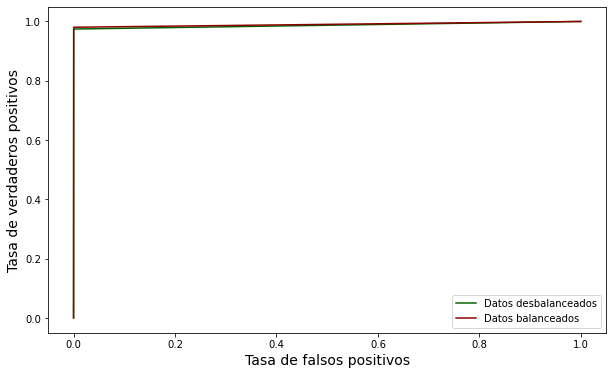

In [31]:
# Importación de librerias.
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, RocCurveDisplay

# Obtención de la curva ROC
fpr_unbalanced, tpr_unbalanced, thresholds_unbalanced = roc_curve(y_true = y_test_unbalanced, y_score = y_pred_unbalanced)
disp_unbalanced = RocCurveDisplay(fpr = fpr_unbalanced, tpr = tpr_unbalanced)

fpr_balanced, tpr_balanced, thresholds_balanced = roc_curve(y_true = y_test_balanced, y_score = y_pred_balanced)
disp_balanced = RocCurveDisplay(fpr = fpr_balanced, tpr = tpr_balanced)

fig = plt.figure(figsize = (10,6))
ax = plt.axes()
disp_unbalanced.plot(ax = ax, c = 'darkgreen')
disp_balanced.plot(ax = ax, c = 'darkred')
ax.set_xlabel(xlabel = 'Tasa de falsos positivos', fontdict = {'fontsize' : 14})
ax.set_ylabel(ylabel = 'Tasa de verdaderos positivos', fontdict = {'fontsize' : 14})
ax.legend(['Datos desbalanceados', 'Datos balanceados'])
plt.savefig('.//figures//' + filename + '_both_roc_curve.png')

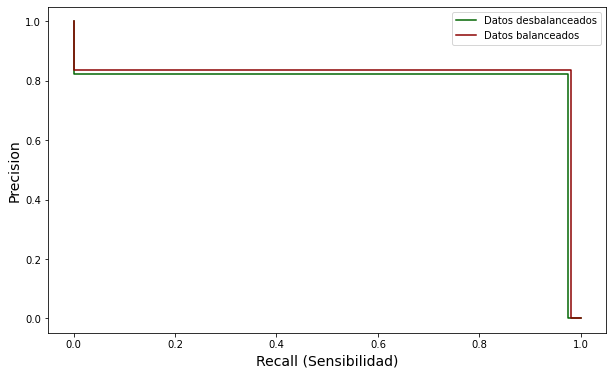

In [32]:
# Importación de librerias.
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

# Obtención de la curva Recall - Precision
prec_unbalanced, recall_unbalanced, _unbalanced = precision_recall_curve(y_true = y_test_unbalanced, probas_pred = y_pred_unbalanced)
disp_unbalanced = PrecisionRecallDisplay(precision = prec_unbalanced, recall = recall_unbalanced)

prec_balanced, recall_balanced, _balanced = precision_recall_curve(y_true = y_test_balanced, probas_pred = y_pred_balanced)
disp_balanced = PrecisionRecallDisplay(precision = prec_balanced, recall = recall_balanced)

fig = plt.figure(figsize = (10,6))
ax = plt.axes()
disp_unbalanced.plot(ax = ax, c = 'darkgreen')
disp_balanced.plot(ax = ax, c = 'darkred')
ax.set_xlabel(xlabel = 'Recall (Sensibilidad)', fontdict = {'fontsize' : 14})
ax.set_ylabel(ylabel = 'Precision', fontdict = {'fontsize' : 14})
ax.legend(['Datos desbalanceados', 'Datos balanceados'])
plt.savefig('.//figures//' + filename + '_both_precision_recall.png')

In [33]:
# Almacenamiento del modelo.
from joblib import dump, load
dump(value = clf_unbalanced, filename = './/models//' + filename + '_unbalanced.joblib')
dump(value = clf_balanced, filename = './/models//' + filename + '_balanced.joblib')

['.//models//bagging_nn_balanced.joblib']

### Gradient Boosted Trees

In [25]:
%%time
# Importación de librerias.
from sklearn.ensemble import GradientBoostingClassifier

# Espacio de busqueda. Datos desbalanceados.
columns = ['isFraud', 'isFlaggedFraud']
scaler = None
params = {'learning_rate': 0.014597559184290473, 'max_depth': 7, 'max_features': 0.9483428205765961, 
          'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 15, 'random_state': 42, 'subsample': 0.9209868180465507}

# Espacio de busqueda. Datos balanceados.
columns_balanced = ['isFraud', 'isFlaggedFraud']
scaler_balanced = None
params_balanced = {'learning_rate': 0.08559612517281782, 'max_depth': 8, 'max_features': 0.9275470891227539, 'min_samples_leaf': 2, 
                   'min_samples_split': 3, 'n_estimators': 20, 'random_state': 42, 'subsample': 0.9502113659155212}

# Nombre de archivo.
filename = 'gbt'

# Ejecución del modelo.
print('Unbalanced: ')
y_test_unbalanced, y_pred_unbalanced, clf_unbalanced = ml_train_test(data_training = df_training, 
                                                                     data_validation = df_validation,
                                                                     estimator = GradientBoostingClassifier(**params),
                                                                     dropped_columns = columns, 
                                                                     scaler = scaler, 
                                                                     balanced = False)
print('\nBalanced: ')
y_test_balanced, y_pred_balanced, clf_balanced = ml_train_test(data_training = df_training, 
                                                               data_validation = df_validation, 
                                                               estimator = GradientBoostingClassifier(**params_balanced), 
                                                               dropped_columns = columns_balanced,
                                                               scaler = scaler_balanced,
                                                               balanced = True)

Unbalanced: 
Recall: 0.7310
Precision: 0.9246
AUC: 0.8655
Accuracy: 0.9996
F1-Score: 0.8165

Balanced: 
Recall: 0.8691
Precision: 0.7596
AUC: 0.9344
Accuracy: 0.9995
F1-Score: 0.8107
CPU times: total: 10min 3s
Wall time: 10min 3s


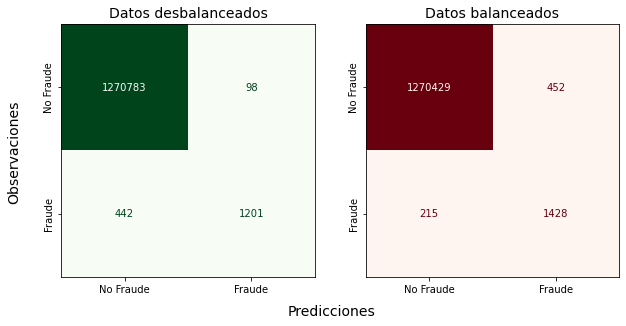

In [26]:
# Importación de librerias.
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix

# Obtención de la matriz de confusión
cm_unbalanced = confusion_matrix(y_true = y_test_unbalanced, y_pred = y_pred_unbalanced)
disp_unbalanced = ConfusionMatrixDisplay(cm_unbalanced, display_labels = ['No Fraude', 'Fraude'])

cm_balanced = confusion_matrix(y_true = y_test_balanced, y_pred = y_pred_balanced)
disp_balanced = ConfusionMatrixDisplay(cm_balanced, display_labels = ['No Fraude', 'Fraude'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,6))
disp_unbalanced.plot(ax = ax1, values_format = 'd', cmap = 'Greens') #tab20b
disp_unbalanced.im_.colorbar.remove()
disp_balanced.plot(ax = ax2, values_format = 'd', cmap = 'Reds')
disp_balanced.im_.colorbar.remove()

ax1.set_xlabel(xlabel = '', fontdict = {'fontsize' : 14})
ax1.set_ylabel(ylabel = '', fontdict = {'fontsize' : 14})
ax1.set_title('Datos desbalanceados', fontsize = 14)
ax2.set_xlabel(xlabel = '', fontdict = {'fontsize' : 14})
ax2.set_ylabel(ylabel = '', fontdict = {'fontsize' : 14})
ax2.set_title('Datos balanceados', fontsize = 14)
ax2.set_yticklabels(labels = ['No Fraude', 'Fraude'], rotation = 90, va = 'center')
ax1.set_yticklabels(labels = ['No Fraude', 'Fraude'], rotation = 90, va = 'center')
fig.text(0.5, 0.12, 'Predicciones', ha = 'center', fontdict = {'fontsize' : 14})
fig.text(0.05, 0.5, 'Observaciones', va = 'center', rotation = 'vertical', fontdict = {'fontsize' : 14})

plt.savefig('.//figures//' + filename + '_both_confusion_matrix.png')

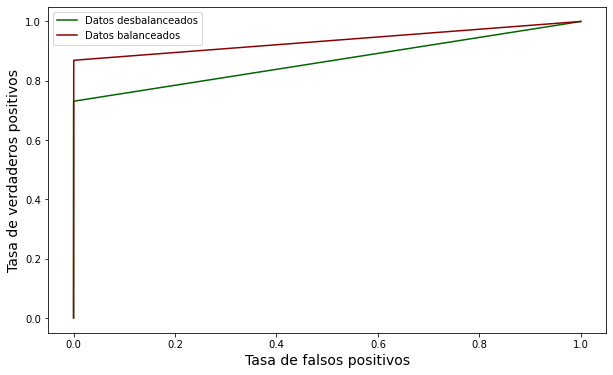

In [27]:
# Importación de librerias.
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, RocCurveDisplay

# Obtención de la curva ROC
fpr_unbalanced, tpr_unbalanced, thresholds_unbalanced = roc_curve(y_true = y_test_unbalanced, y_score = y_pred_unbalanced)
disp_unbalanced = RocCurveDisplay(fpr = fpr_unbalanced, tpr = tpr_unbalanced)

fpr_balanced, tpr_balanced, thresholds_balanced = roc_curve(y_true = y_test_balanced, y_score = y_pred_balanced)
disp_balanced = RocCurveDisplay(fpr = fpr_balanced, tpr = tpr_balanced)

fig = plt.figure(figsize = (10,6))
ax = plt.axes()
disp_unbalanced.plot(ax = ax, c = 'darkgreen')
disp_balanced.plot(ax = ax, c = 'darkred')
ax.set_xlabel(xlabel = 'Tasa de falsos positivos', fontdict = {'fontsize' : 14})
ax.set_ylabel(ylabel = 'Tasa de verdaderos positivos', fontdict = {'fontsize' : 14})
ax.legend(['Datos desbalanceados', 'Datos balanceados'])
plt.savefig('.//figures//' + filename + '_both_roc_curve.png')

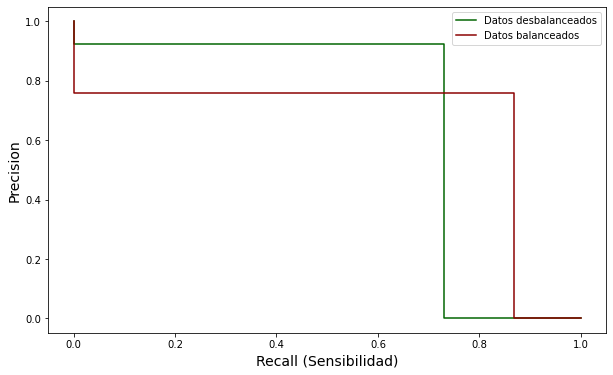

In [28]:
# Importación de librerias.
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

# Obtención de la curva Recall - Precision
prec_unbalanced, recall_unbalanced, _unbalanced = precision_recall_curve(y_true = y_test_unbalanced, probas_pred = y_pred_unbalanced)
disp_unbalanced = PrecisionRecallDisplay(precision = prec_unbalanced, recall = recall_unbalanced)

prec_balanced, recall_balanced, _balanced = precision_recall_curve(y_true = y_test_balanced, probas_pred = y_pred_balanced)
disp_balanced = PrecisionRecallDisplay(precision = prec_balanced, recall = recall_balanced)

fig = plt.figure(figsize = (10,6))
ax = plt.axes()
disp_unbalanced.plot(ax = ax, c = 'darkgreen')
disp_balanced.plot(ax = ax, c = 'darkred')
ax.set_xlabel(xlabel = 'Recall (Sensibilidad)', fontdict = {'fontsize' : 14})
ax.set_ylabel(ylabel = 'Precision', fontdict = {'fontsize' : 14})
ax.legend(['Datos desbalanceados', 'Datos balanceados'])
plt.savefig('.//figures//' + filename + '_both_precision_recall.png')

In [29]:
# Almacenamiento del modelo.
from joblib import dump, load
dump(value = clf_unbalanced, filename = './/models//' + filename + '_unbalanced.joblib')
dump(value = clf_balanced, filename = './/models//' + filename + '_balanced.joblib')

['.//models//gbt_balanced.joblib']

### XGBoost

In [31]:
%%time
# Importación de librerias.
from xgboost import XGBClassifier

# Espacio de busqueda. Datos desbalanceados.
columns = ['isFraud', 'isFlaggedFraud']
scaler = None
params = {'n_estimators': 630, 'colsample_bylevel': 0.67144859255828, 'colsample_bynode': 0.7831315094844271, 'colsample_bytree': 0.8014899183766985, 
            'gamma': 0.014974393635115657, 'gpu_id': 0, 'learning_rate': 0.05, 'max_delta_step': 0.9959894166399985, 'max_depth': 7, 
            'min_child_weight': 0.7431045276160863, 'random_state': 42, 'reg_alpha': 0.5395766188121431, 'reg_lambda': 0.3611246194409444, 
            'scale_pos_weight': 0.9983922138002084, 'subsample': 0.9933497238368184, 'tree_method': 'gpu_hist'}

# Espacio de busqueda. Datos balanceados.
columns_balanced = ['isFraud', 'isFlaggedFraud']
scaler_balanced = None
params_balanced =  {'colsample_bylevel': 0.5159289901788265, 'colsample_bynode': 0.683421710672661, 'colsample_bytree': 0.9229862438842107, 'gamma': 0.1542273620039968, 
                       'gpu_id': 0, 'learning_rate': 0.15, 'max_delta_step': 0.9988063160725104, 'max_depth': 4, 'min_child_weight': 0.498151114117041, 'n_estimators': 304, 
                       'random_state': 42, 'reg_alpha': 0.7617504152023389, 'reg_lambda': 0.051201180233103605, 'scale_pos_weight': 0.9423971486162506, 'subsample': 0.6492775907229061, 
                       'tree_method': 'gpu_hist'}

# Nombre de archivo.
filename = 'xgb'

# Ejecución del modelo.
print('Unbalanced: ')
y_test_unbalanced, y_pred_unbalanced, clf_unbalanced = ml_train_test(data_training = df_training, 
                                                                     data_validation = df_validation,
                                                                     estimator = XGBClassifier(**params),
                                                                     dropped_columns = columns, 
                                                                     scaler = scaler, 
                                                                     balanced = False)
print('\nBalanced: ')
y_test_balanced, y_pred_balanced, clf_balanced = ml_train_test(data_training = df_training, 
                                                               data_validation = df_validation, 
                                                               estimator = XGBClassifier(**params_balanced), 
                                                               dropped_columns = columns_balanced,
                                                               scaler = scaler_balanced,
                                                               balanced = True)

Unbalanced: 
Recall: 0.8363
Precision: 0.9752
AUC: 0.9181
Accuracy: 0.9998
F1-Score: 0.9004

Balanced: 
Recall: 0.9002
Precision: 0.8554
AUC: 0.9500
Accuracy: 0.9997
F1-Score: 0.8772
CPU times: total: 1min 21s
Wall time: 45.7 s


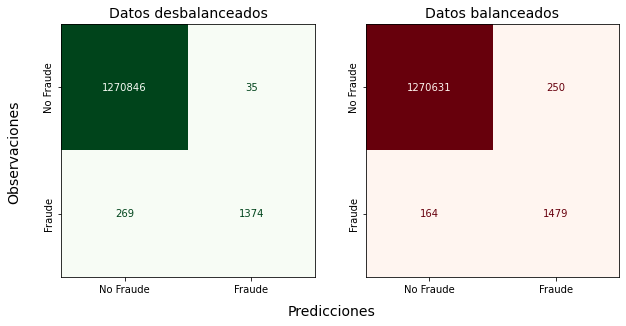

In [32]:
# Importación de librerias.
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix

# Obtención de la matriz de confusión
cm_unbalanced = confusion_matrix(y_true = y_test_unbalanced, y_pred = y_pred_unbalanced)
disp_unbalanced = ConfusionMatrixDisplay(cm_unbalanced, display_labels = ['No Fraude', 'Fraude'])

cm_balanced = confusion_matrix(y_true = y_test_balanced, y_pred = y_pred_balanced)
disp_balanced = ConfusionMatrixDisplay(cm_balanced, display_labels = ['No Fraude', 'Fraude'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,6))
disp_unbalanced.plot(ax = ax1, values_format = 'd', cmap = 'Greens') #tab20b
disp_unbalanced.im_.colorbar.remove()
disp_balanced.plot(ax = ax2, values_format = 'd', cmap = 'Reds')
disp_balanced.im_.colorbar.remove()

ax1.set_xlabel(xlabel = '', fontdict = {'fontsize' : 14})
ax1.set_ylabel(ylabel = '', fontdict = {'fontsize' : 14})
ax1.set_title('Datos desbalanceados', fontsize = 14)
ax2.set_xlabel(xlabel = '', fontdict = {'fontsize' : 14})
ax2.set_ylabel(ylabel = '', fontdict = {'fontsize' : 14})
ax2.set_title('Datos balanceados', fontsize = 14)
ax2.set_yticklabels(labels = ['No Fraude', 'Fraude'], rotation = 90, va = 'center')
ax1.set_yticklabels(labels = ['No Fraude', 'Fraude'], rotation = 90, va = 'center')
fig.text(0.5, 0.12, 'Predicciones', ha = 'center', fontdict = {'fontsize' : 14})
fig.text(0.05, 0.5, 'Observaciones', va = 'center', rotation = 'vertical', fontdict = {'fontsize' : 14})

plt.savefig('.//figures//' + filename + '_both_confusion_matrix.png')

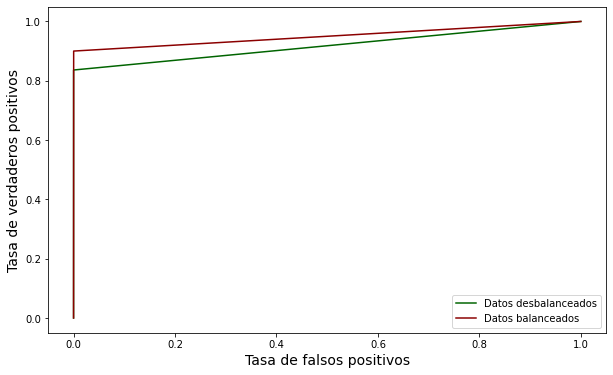

In [33]:
# Importación de librerias.
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, RocCurveDisplay

# Obtención de la curva ROC
fpr_unbalanced, tpr_unbalanced, thresholds_unbalanced = roc_curve(y_true = y_test_unbalanced, y_score = y_pred_unbalanced)
disp_unbalanced = RocCurveDisplay(fpr = fpr_unbalanced, tpr = tpr_unbalanced)

fpr_balanced, tpr_balanced, thresholds_balanced = roc_curve(y_true = y_test_balanced, y_score = y_pred_balanced)
disp_balanced = RocCurveDisplay(fpr = fpr_balanced, tpr = tpr_balanced)

fig = plt.figure(figsize = (10,6))
ax = plt.axes()
disp_unbalanced.plot(ax = ax, c = 'darkgreen')
disp_balanced.plot(ax = ax, c = 'darkred')
ax.set_xlabel(xlabel = 'Tasa de falsos positivos', fontdict = {'fontsize' : 14})
ax.set_ylabel(ylabel = 'Tasa de verdaderos positivos', fontdict = {'fontsize' : 14})
ax.legend(['Datos desbalanceados', 'Datos balanceados'])
plt.savefig('.//figures//' + filename + '_both_roc_curve.png')

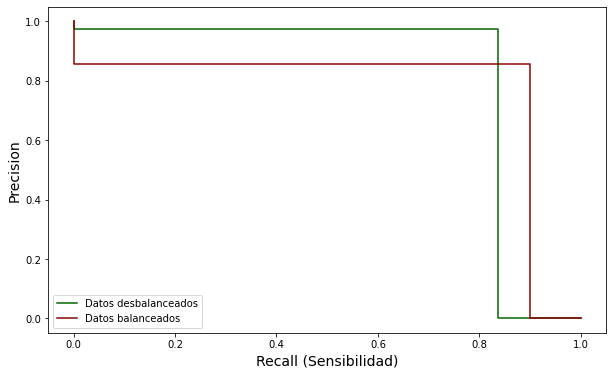

In [34]:
# Importación de librerias.
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

# Obtención de la curva Recall - Precision
prec_unbalanced, recall_unbalanced, _unbalanced = precision_recall_curve(y_true = y_test_unbalanced, probas_pred = y_pred_unbalanced)
disp_unbalanced = PrecisionRecallDisplay(precision = prec_unbalanced, recall = recall_unbalanced)

prec_balanced, recall_balanced, _balanced = precision_recall_curve(y_true = y_test_balanced, probas_pred = y_pred_balanced)
disp_balanced = PrecisionRecallDisplay(precision = prec_balanced, recall = recall_balanced)

fig = plt.figure(figsize = (10,6))
ax = plt.axes()
disp_unbalanced.plot(ax = ax, c = 'darkgreen')
disp_balanced.plot(ax = ax, c = 'darkred')
ax.set_xlabel(xlabel = 'Recall (Sensibilidad)', fontdict = {'fontsize' : 14})
ax.set_ylabel(ylabel = 'Precision', fontdict = {'fontsize' : 14})
ax.legend(['Datos desbalanceados', 'Datos balanceados'])
plt.savefig('.//figures//' + filename + '_both_precision_recall.png')

In [35]:
# Almacenamiento del modelo.
from joblib import dump, load
dump(value = clf_unbalanced, filename = './/models//' + filename + '_unbalanced.joblib')
dump(value = clf_balanced, filename = './/models//' + filename + '_balanced.joblib')

['.//models//xgb_balanced.joblib']

### K-Means

In [3]:
# Importación de librerias.
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

# Definición de función.
def ml_train_test_2(data_training, data_validation, estimator, dropped_columns, scaler = None, balanced = False):
    
    # Subset de datos
    X_train = data_training.drop(labels = dropped_columns, axis = 1)
    y_train = data_training['isFraud']
    X_test = data_validation.drop(labels = dropped_columns, axis = 1)
    y_test = data_validation['isFraud']
    
    # Scaling
    if scaler == None:
        X_train = X_train
        X_test = X_test
    else:
        train_index = X_train.index
        train_columns = X_train.columns
        X_train = pd.DataFrame(scaler.fit_transform(X_train))
        X_train.index = train_index
        X_train.columns = train_columns
        
        test_index = X_test.index
        test_columns = X_test.columns
        X_test = pd.DataFrame(scaler.fit_transform(X_test))
        X_test.index = test_index
        X_test.columns = test_columns
    
    # Balanceo de datos
    if balanced == True:
        indexes = balancing(X_train, y_train, 0.8)
        X_train = X_train.loc[indexes, :]
        y_train = y_train.loc[indexes]
    else:
        X_train = X_train
        y_train = y_train
    
    # Entrenamiento del modelo.
    clf = estimator
    clf.fit(X_train)
    
    # Predicción de valores.
    y_pred = clf.predict(X_test)
    
    if sum(y_pred) <= (len(y_pred) - sum(y_pred)):
        None
    else:
        for i, j in enumerate(y_pred):
            if j == 0:
                y_pred[i] = 1
            else:
                y_pred[i] = 0
    
    # Obtención de metricas.
    print('Recall: %.4f' % recall_score(y_true = y_test, y_pred = y_pred))
    print('Precision: %.4f' % precision_score(y_true = y_test, y_pred = y_pred))
    print('AUC: %.4f' % roc_auc_score(y_true = y_test, y_score = y_pred))
    print('Accuracy: %.4f' % accuracy_score(y_true = y_test, y_pred = y_pred))
    print('F1-Score: %.4f' % f1_score(y_true = y_test, y_pred = y_pred))
    
    return y_test, y_pred, clf

In [4]:
%%time
# Importación de librerias.
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from math import ceil

# Espacio de busqueda. Datos desbalanceados.
columns = ['day', 'idOrig', 'oldbalanceOrig', 'newbalanceOrig', 'oldbalanceDest', 'isFraud', 'isFlaggedFraud']
scaler = RobustScaler()
params = {'n_clusters' : 2, 'algorithm': 'full', 'init': 'k-means++', 'max_iter': ceil(0.749941889542941), 'n_init': ceil(13.707328356680836), 'tol': 6.031336125338633e-05, 'random_state': 42}

# Espacio de busqueda. Datos balanceados.
columns_balanced = ['isFraud', 'isFlaggedFraud', 'hour', 'idOrig', 'oldbalanceOrig', 'newbalanceOrig', 'idDest', 'oldbalanceDest', 'newbalanceDest']
scaler_balanced = None
params_balanced =  {'n_clusters' : 2, 'algorithm': 'elkan', 'init': 'k-means++', 'max_iter': ceil(751.7078348491474), 'n_init': ceil(19.780200199103444), 'tol': 9.847864526853775e-05, 'random_state': 42}

# Nombre de archivo.
filename = 'kmeans'

# Ejecución del modelo.
print('Unbalanced: ')
y_test_unbalanced, y_pred_unbalanced, clf_unbalanced = ml_train_test_2(data_training = df_training, 
                                                                       data_validation = df_validation,
                                                                       estimator = KMeans(**params),
                                                                       dropped_columns = columns, 
                                                                       scaler = scaler, 
                                                                       balanced = False)
print('\nBalanced: ')
y_test_balanced, y_pred_balanced, clf_balanced = ml_train_test_2(data_training = df_training, 
                                                                 data_validation = df_validation, 
                                                                 estimator = KMeans(**params_balanced), 
                                                                 dropped_columns = columns_balanced,
                                                                 scaler = scaler_balanced,
                                                                 balanced = True)

Unbalanced: 
Recall: 0.0651
Precision: 0.0431
AUC: 0.5316
Accuracy: 0.9969
F1-Score: 0.0519

Balanced: 
Recall: 0.0907
Precision: 0.0645
AUC: 0.5445
Accuracy: 0.9971
F1-Score: 0.0754
CPU times: total: 1min 8s
Wall time: 16.6 s


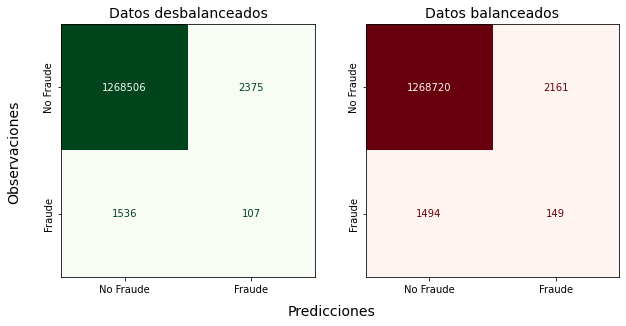

In [5]:
# Importación de librerias.
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix

# Obtención de la matriz de confusión
cm_unbalanced = confusion_matrix(y_true = y_test_unbalanced, y_pred = y_pred_unbalanced)
disp_unbalanced = ConfusionMatrixDisplay(cm_unbalanced, display_labels = ['No Fraude', 'Fraude'])

cm_balanced = confusion_matrix(y_true = y_test_balanced, y_pred = y_pred_balanced)
disp_balanced = ConfusionMatrixDisplay(cm_balanced, display_labels = ['No Fraude', 'Fraude'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,6))
disp_unbalanced.plot(ax = ax1, values_format = 'd', cmap = 'Greens') #tab20b
disp_unbalanced.im_.colorbar.remove()
disp_balanced.plot(ax = ax2, values_format = 'd', cmap = 'Reds')
disp_balanced.im_.colorbar.remove()

ax1.set_xlabel(xlabel = '', fontdict = {'fontsize' : 14})
ax1.set_ylabel(ylabel = '', fontdict = {'fontsize' : 14})
ax1.set_title('Datos desbalanceados', fontsize = 14)
ax2.set_xlabel(xlabel = '', fontdict = {'fontsize' : 14})
ax2.set_ylabel(ylabel = '', fontdict = {'fontsize' : 14})
ax2.set_title('Datos balanceados', fontsize = 14)
ax2.set_yticklabels(labels = ['No Fraude', 'Fraude'], rotation = 90, va = 'center')
ax1.set_yticklabels(labels = ['No Fraude', 'Fraude'], rotation = 90, va = 'center')
fig.text(0.5, 0.12, 'Predicciones', ha = 'center', fontdict = {'fontsize' : 14})
fig.text(0.05, 0.5, 'Observaciones', va = 'center', rotation = 'vertical', fontdict = {'fontsize' : 14})

plt.savefig('.//figures//' + filename + '_both_confusion_matrix.png')

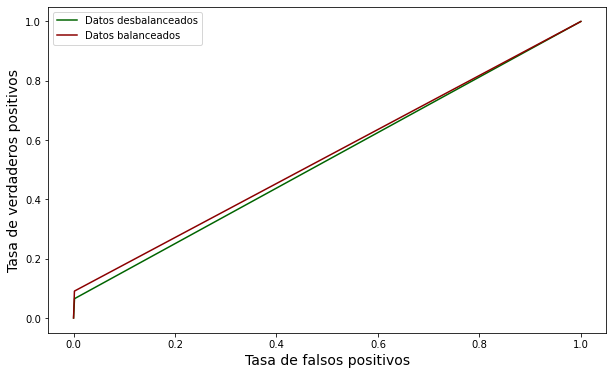

In [6]:
# Importación de librerias.
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, RocCurveDisplay

# Obtención de la curva ROC
fpr_unbalanced, tpr_unbalanced, thresholds_unbalanced = roc_curve(y_true = y_test_unbalanced, y_score = y_pred_unbalanced)
disp_unbalanced = RocCurveDisplay(fpr = fpr_unbalanced, tpr = tpr_unbalanced)

fpr_balanced, tpr_balanced, thresholds_balanced = roc_curve(y_true = y_test_balanced, y_score = y_pred_balanced)
disp_balanced = RocCurveDisplay(fpr = fpr_balanced, tpr = tpr_balanced)

fig = plt.figure(figsize = (10,6))
ax = plt.axes()
disp_unbalanced.plot(ax = ax, c = 'darkgreen')
disp_balanced.plot(ax = ax, c = 'darkred')
ax.set_xlabel(xlabel = 'Tasa de falsos positivos', fontdict = {'fontsize' : 14})
ax.set_ylabel(ylabel = 'Tasa de verdaderos positivos', fontdict = {'fontsize' : 14})
ax.legend(['Datos desbalanceados', 'Datos balanceados'])
plt.savefig('.//figures//' + filename + '_both_roc_curve.png')

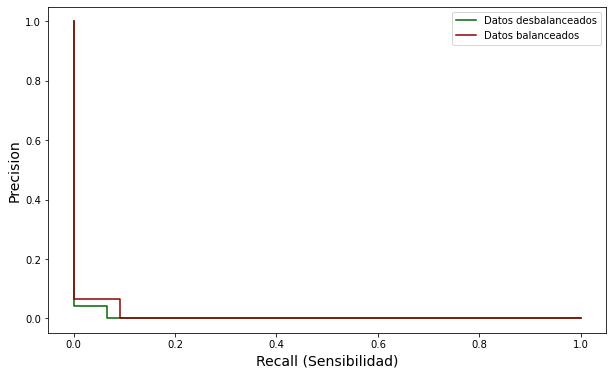

In [7]:
# Importación de librerias.
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

# Obtención de la curva Recall - Precision
prec_unbalanced, recall_unbalanced, _unbalanced = precision_recall_curve(y_true = y_test_unbalanced, probas_pred = y_pred_unbalanced)
disp_unbalanced = PrecisionRecallDisplay(precision = prec_unbalanced, recall = recall_unbalanced)

prec_balanced, recall_balanced, _balanced = precision_recall_curve(y_true = y_test_balanced, probas_pred = y_pred_balanced)
disp_balanced = PrecisionRecallDisplay(precision = prec_balanced, recall = recall_balanced)

fig = plt.figure(figsize = (10,6))
ax = plt.axes()
disp_unbalanced.plot(ax = ax, c = 'darkgreen')
disp_balanced.plot(ax = ax, c = 'darkred')
ax.set_xlabel(xlabel = 'Recall (Sensibilidad)', fontdict = {'fontsize' : 14})
ax.set_ylabel(ylabel = 'Precision', fontdict = {'fontsize' : 14})
ax.legend(['Datos desbalanceados', 'Datos balanceados'])
plt.savefig('.//figures//' + filename + '_both_precision_recall.png')

In [8]:
# Almacenamiento del modelo.
from joblib import dump, load
dump(value = clf_unbalanced, filename = './/models//' + filename + '_unbalanced.joblib')
dump(value = clf_balanced, filename = './/models//' + filename + '_balanced.joblib')

['.//models//kmeans_balanced.joblib']

In [9]:
# Creación de paleta de colores.
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

greens_new = np.zeros(shape = (4,4))
greens_new[0, :] = cm.get_cmap('Greens', 100)(25)
greens_new[1, :] = cm.get_cmap('Greens', 100)(50)
greens_new[2, :] = cm.get_cmap('Greens', 100)(75)
greens_new[3, :] = cm.get_cmap('Greens', 100)(100)

reds_new = np.zeros(shape = (4,4))
reds_new[0, :] = cm.get_cmap('Reds', 100)(25)
reds_new[1, :] = cm.get_cmap('Reds', 100)(50)
reds_new[2, :] = cm.get_cmap('Reds', 100)(75)
reds_new[3, :] = cm.get_cmap('Reds', 100)(100)

greens_cmp = ListedColormap(greens_new)
reds_cmp = ListedColormap(reds_new)

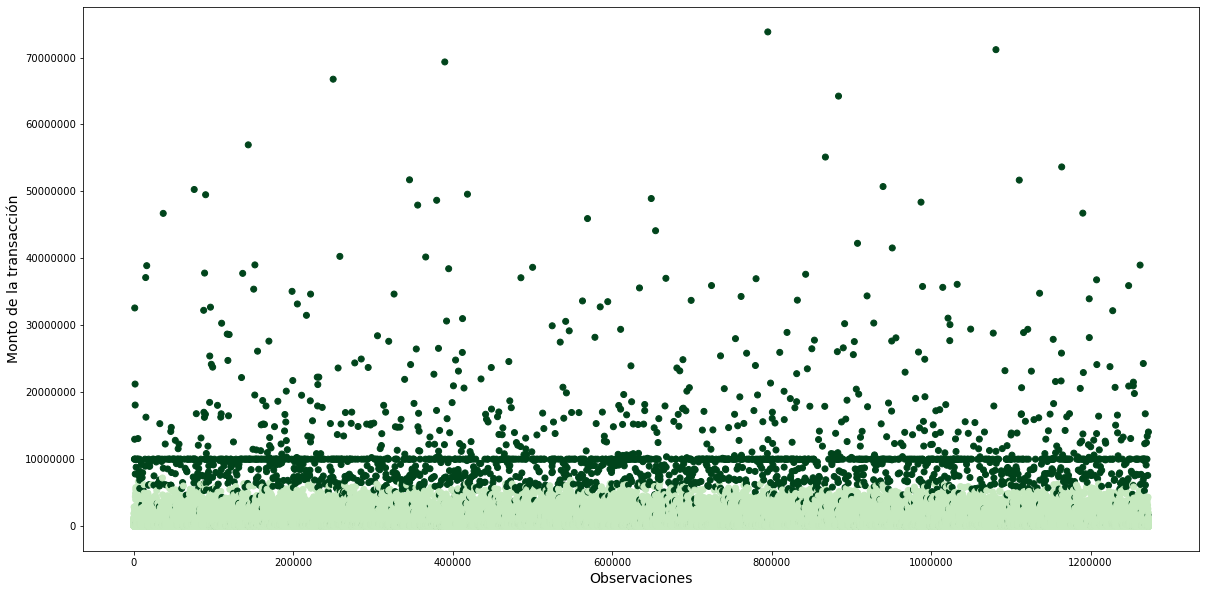

In [10]:
# K-Means. Datos desbalanceados. Gráfico de dispersión de registros anómalos.
from matplotlib.ticker import FormatStrFormatter

df_disp = pd.DataFrame({'amount' : df_validation.amount, 'prediction_unbalanced' : y_pred_unbalanced, 'prediction_balanced' : y_pred_balanced})
df_disp = df_disp.reset_index()

fig, ax = plt.subplots(figsize = (20, 10))
ax.scatter(x = df_disp.index, y = df_disp.amount, c = df_disp.prediction_unbalanced, cmap = greens_cmp)
ax.set_xlabel('Observaciones', fontdict = {'fontsize' : 14})
ax.set_ylabel('Monto de la transacción', fontdict = {'fontsize' : 14})
ax.xaxis.set_major_formatter(FormatStrFormatter('%i'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%i'))
plt.savefig('.//figures//' + filename + '_scatter_unbalanced.png')

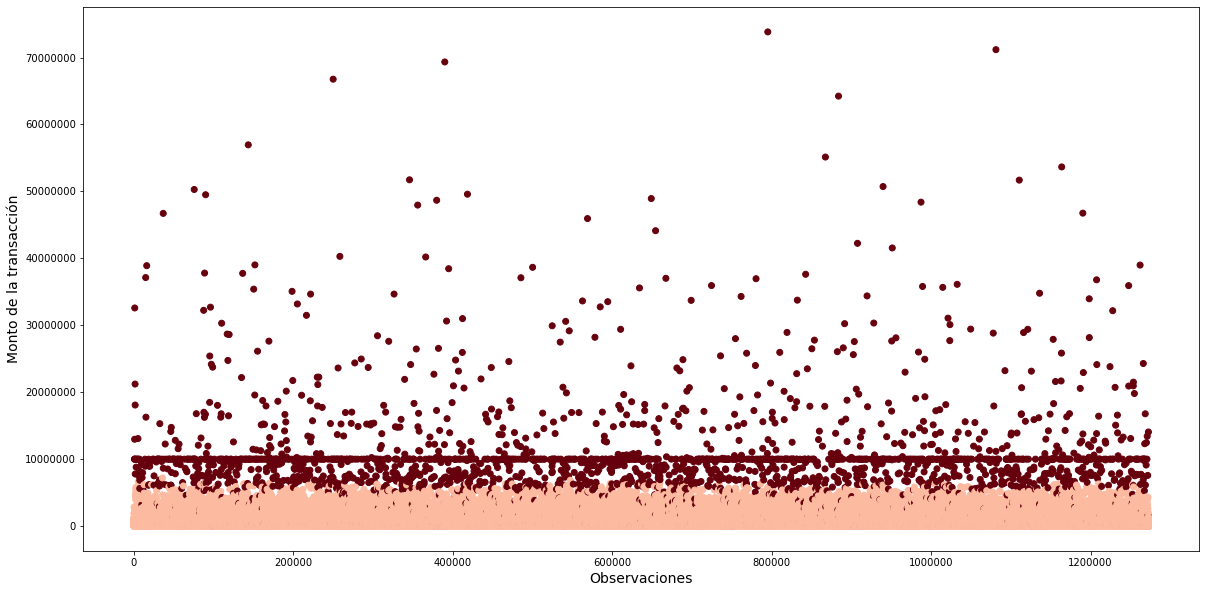

In [11]:
# K-Means. Datos balanceados. Gráfico de dispersión de registros anómalos.
df_disp = pd.DataFrame({'amount' : df_validation.amount, 'prediction_unbalanced' : y_pred_unbalanced, 'prediction_balanced' : y_pred_balanced})
df_disp = df_disp.reset_index()

fig, ax = plt.subplots(figsize = (20, 10))
ax.scatter(x = df_disp.index, y = df_disp.amount, c = df_disp.prediction_unbalanced, cmap = reds_cmp)
ax.set_xlabel('Observaciones', fontdict = {'fontsize' : 14})
ax.set_ylabel('Monto de la transacción', fontdict = {'fontsize' : 14})
ax.xaxis.set_major_formatter(FormatStrFormatter('%i'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%i'))
plt.savefig('.//figures//' + filename + '_scatter_balanced.png')

### PyCaret

In [7]:
# Importación de librerias.
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

filename = 'pycaret'

y_test_unbalanced = pd.read_csv('pycaret_ytest_unbalanced.csv', index_col = 0)
y_pred_unbalanced = pd.read_csv('pycaret_ypred_unbalanced.csv', index_col = 0)
y_test_balanced = pd.read_csv('pycaret_ytest_balanced.csv', index_col = 0)
y_pred_balanced = pd.read_csv('pycaret_ypred_balanced.csv', index_col = 0)

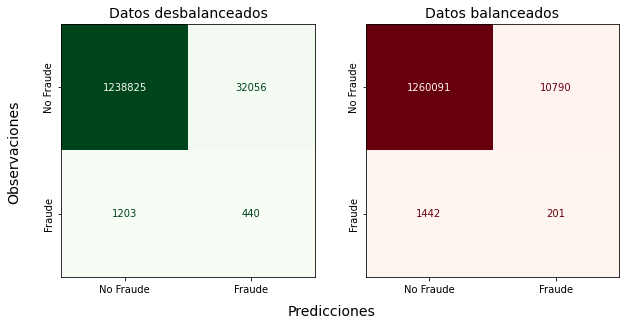

In [9]:
# Importación de librerias.
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix

# Obtención de la matriz de confusión
cm_unbalanced = confusion_matrix(y_true = y_test_unbalanced, y_pred = y_pred_unbalanced)
disp_unbalanced = ConfusionMatrixDisplay(cm_unbalanced, display_labels = ['No Fraude', 'Fraude'])

cm_balanced = confusion_matrix(y_true = y_test_balanced, y_pred = y_pred_balanced)
disp_balanced = ConfusionMatrixDisplay(cm_balanced, display_labels = ['No Fraude', 'Fraude'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,6))
disp_unbalanced.plot(ax = ax1, values_format = 'd', cmap = 'Greens') #tab20b
disp_unbalanced.im_.colorbar.remove()
disp_balanced.plot(ax = ax2, values_format = 'd', cmap = 'Reds')
disp_balanced.im_.colorbar.remove()

ax1.set_xlabel(xlabel = '', fontdict = {'fontsize' : 14})
ax1.set_ylabel(ylabel = '', fontdict = {'fontsize' : 14})
ax1.set_title('Datos desbalanceados', fontsize = 14)
ax2.set_xlabel(xlabel = '', fontdict = {'fontsize' : 14})
ax2.set_ylabel(ylabel = '', fontdict = {'fontsize' : 14})
ax2.set_title('Datos balanceados', fontsize = 14)
ax2.set_yticklabels(labels = ['No Fraude', 'Fraude'], rotation = 90, va = 'center')
ax1.set_yticklabels(labels = ['No Fraude', 'Fraude'], rotation = 90, va = 'center')
fig.text(0.5, 0.12, 'Predicciones', ha = 'center', fontdict = {'fontsize' : 14})
fig.text(0.05, 0.5, 'Observaciones', va = 'center', rotation = 'vertical', fontdict = {'fontsize' : 14})

plt.savefig('.//figures//' + filename + '_both_confusion_matrix.png')

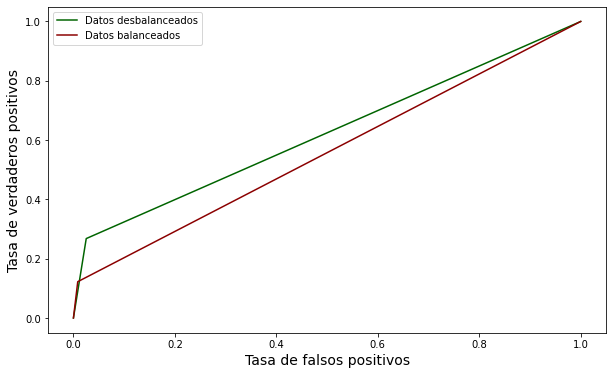

In [10]:
# Importación de librerias.
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, RocCurveDisplay

# Obtención de la curva ROC
fpr_unbalanced, tpr_unbalanced, thresholds_unbalanced = roc_curve(y_true = y_test_unbalanced, y_score = y_pred_unbalanced)
disp_unbalanced = RocCurveDisplay(fpr = fpr_unbalanced, tpr = tpr_unbalanced)

fpr_balanced, tpr_balanced, thresholds_balanced = roc_curve(y_true = y_test_balanced, y_score = y_pred_balanced)
disp_balanced = RocCurveDisplay(fpr = fpr_balanced, tpr = tpr_balanced)

fig = plt.figure(figsize = (10,6))
ax = plt.axes()
disp_unbalanced.plot(ax = ax, c = 'darkgreen')
disp_balanced.plot(ax = ax, c = 'darkred')
ax.set_xlabel(xlabel = 'Tasa de falsos positivos', fontdict = {'fontsize' : 14})
ax.set_ylabel(ylabel = 'Tasa de verdaderos positivos', fontdict = {'fontsize' : 14})
ax.legend(['Datos desbalanceados', 'Datos balanceados'])
plt.savefig('.//figures//' + filename + '_both_roc_curve.png')

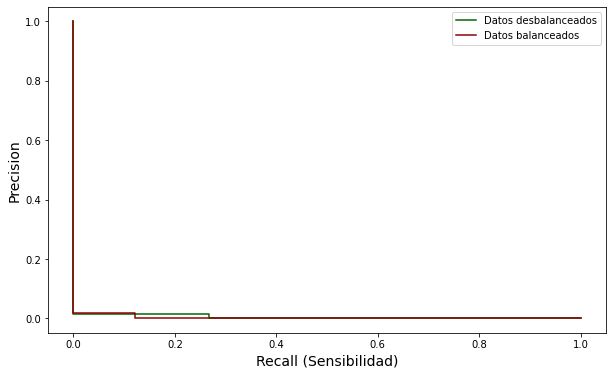

In [11]:
# Importación de librerias.
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

# Obtención de la curva Recall - Precision
prec_unbalanced, recall_unbalanced, _unbalanced = precision_recall_curve(y_true = y_test_unbalanced, probas_pred = y_pred_unbalanced)
disp_unbalanced = PrecisionRecallDisplay(precision = prec_unbalanced, recall = recall_unbalanced)

prec_balanced, recall_balanced, _balanced = precision_recall_curve(y_true = y_test_balanced, probas_pred = y_pred_balanced)
disp_balanced = PrecisionRecallDisplay(precision = prec_balanced, recall = recall_balanced)

fig = plt.figure(figsize = (10,6))
ax = plt.axes()
disp_unbalanced.plot(ax = ax, c = 'darkgreen')
disp_balanced.plot(ax = ax, c = 'darkred')
ax.set_xlabel(xlabel = 'Recall (Sensibilidad)', fontdict = {'fontsize' : 14})
ax.set_ylabel(ylabel = 'Precision', fontdict = {'fontsize' : 14})
ax.legend(['Datos desbalanceados', 'Datos balanceados'])
plt.savefig('.//figures//' + filename + '_both_precision_recall.png')

## Graficos comparativos integrales

In [212]:
# Listado de métricas de los modelos.

all_scores = {
    'baseline' : [0.0019, 1.0000, 0.5010, 0.9987, 0.0039],
    'decision_tree_unbalanced' : [0.8509, 0.9143, 0.9254, 0.9997, 0.8815],
    'decision_tree_balanced' : [0.9519, 0.6194, 0.9756, 0.9992, 0.7505],
    'svm_unbalanced' : [0.8795, 0.1393, 0.9362, 0.9928, 0.2405],
    'svm_balanced' : [0.5338, 0.7929, 0.7668, 0.9992, 0.6381],
    'nn_unbalanced' : [0.9787, 0.8379, 0.9892, 0.9997, 0.9029],
    'nn_balanced' : [0.9805, 0.7553, 0.9901, 0.9996, 0.8533],
    'rf_unbalanced' : [0.8996, 0.9152, 0.9497, 0.9998, 0.9073],
    'rf_balanced' : [0.9507, 0.7385, 0.9751, 0.9995, 0.8313],
    'baggging_svm_unbalanced' : [0.3767, 0.9872, 0.6884, 0.9992, 0.5454],
    'baggging_svm_balanced' : [0.5666, 0.7950, 0.7832, 0.9993, 0.6617],
    'baggging_nn_unbalanced' : [0.9744, 0.8223, 0.9871, 0.9997, 0.8919],
    'baggging_nn_balanced' : [0.9805, 0.8369, 0.9901, 0.9997, 0.9030],
    'gbt_unbalanced' : [0.7310, 0.9246, 0.8655, 0.9996, 0.8165],
    'gbt_balanced' : [0.8691, 0.7596, 0.9344, 0.9995, 0.8107],
    'xgb_unbalanced' : [0.8363, 0.9752, 0.9181, 0.9998, 0.9004],
    'xgb_balanced' : [0.9002, 0.8554, 0.9500, 0.9997, 0.8772],
    'kmeans_unbalanced' : [0.0651, 0.0431, 0.5316, 0.9969, 0.0519],
    'kmeans_balanced' : [0.3244, 0.0006, 0.3066, 0.2888, 0.0012],
    'tukey' : [0.3926, 0.0159, 0.6806, 0.9678, 0.0305],
    'pycaret_unbalanced' : [0.2678, 0.0135, 0.6213, 0.9739, 0.0258],
    'pycaret_balanced' : [0.1223, 0.0183, 0.5569, 0.9904, 0.0318]
}

z = pd.DataFrame(all_scores, index = ['recall', 'precision', 'auc', 'accuracy', 'f1-score'])

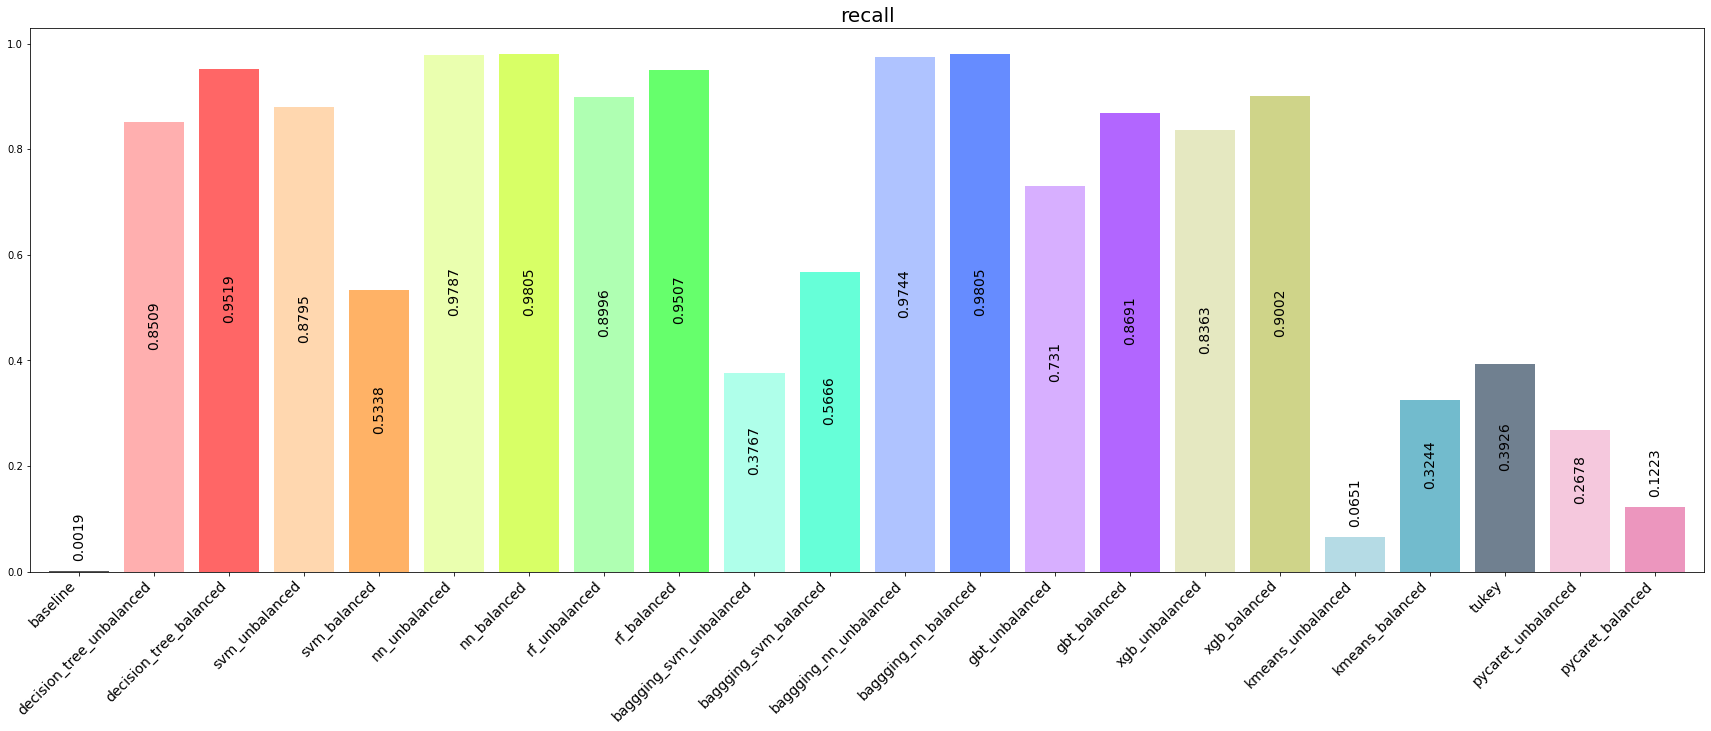

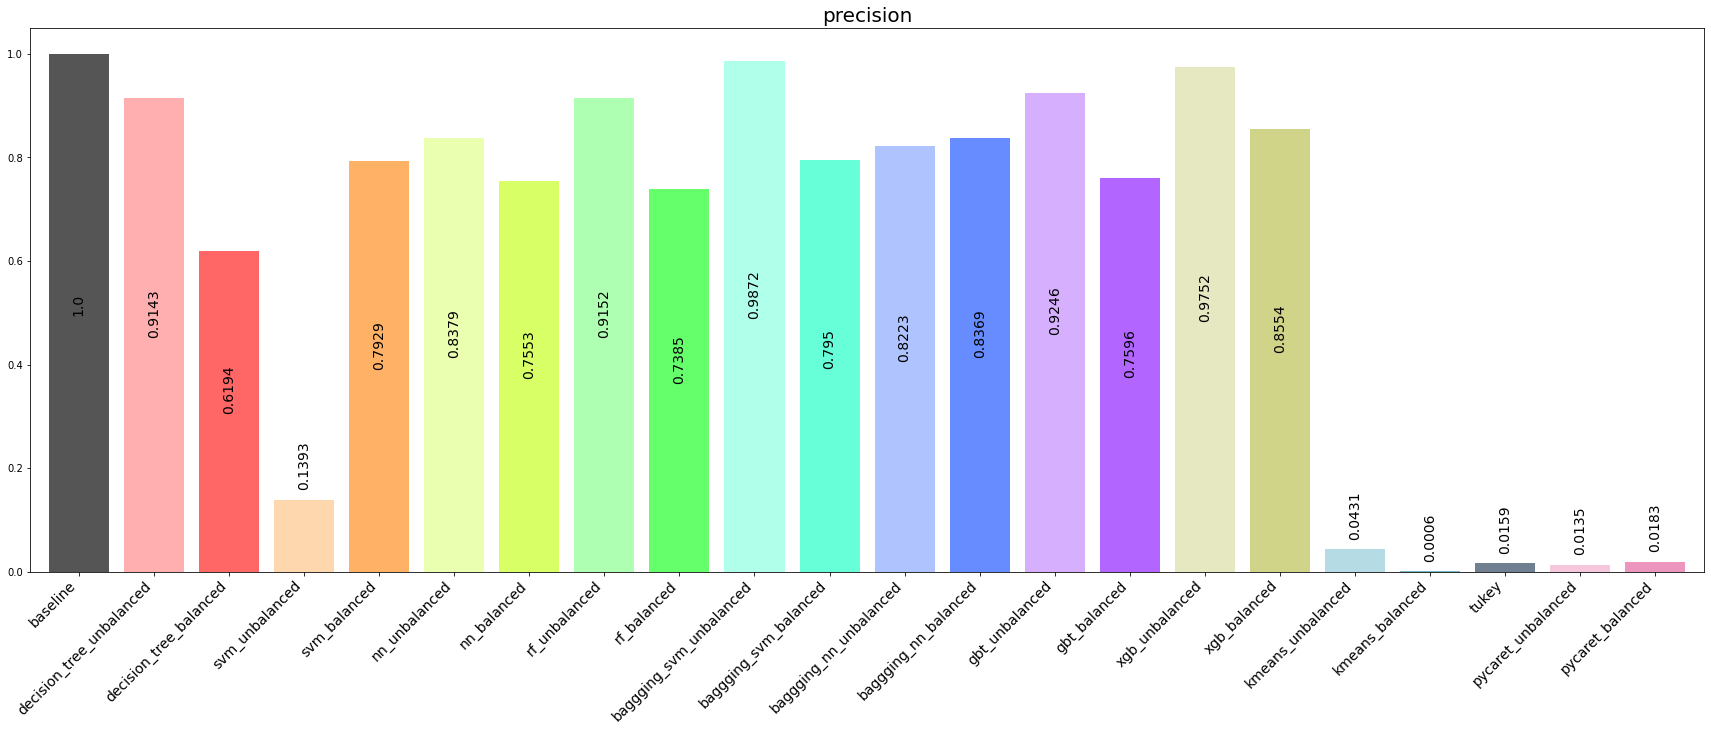

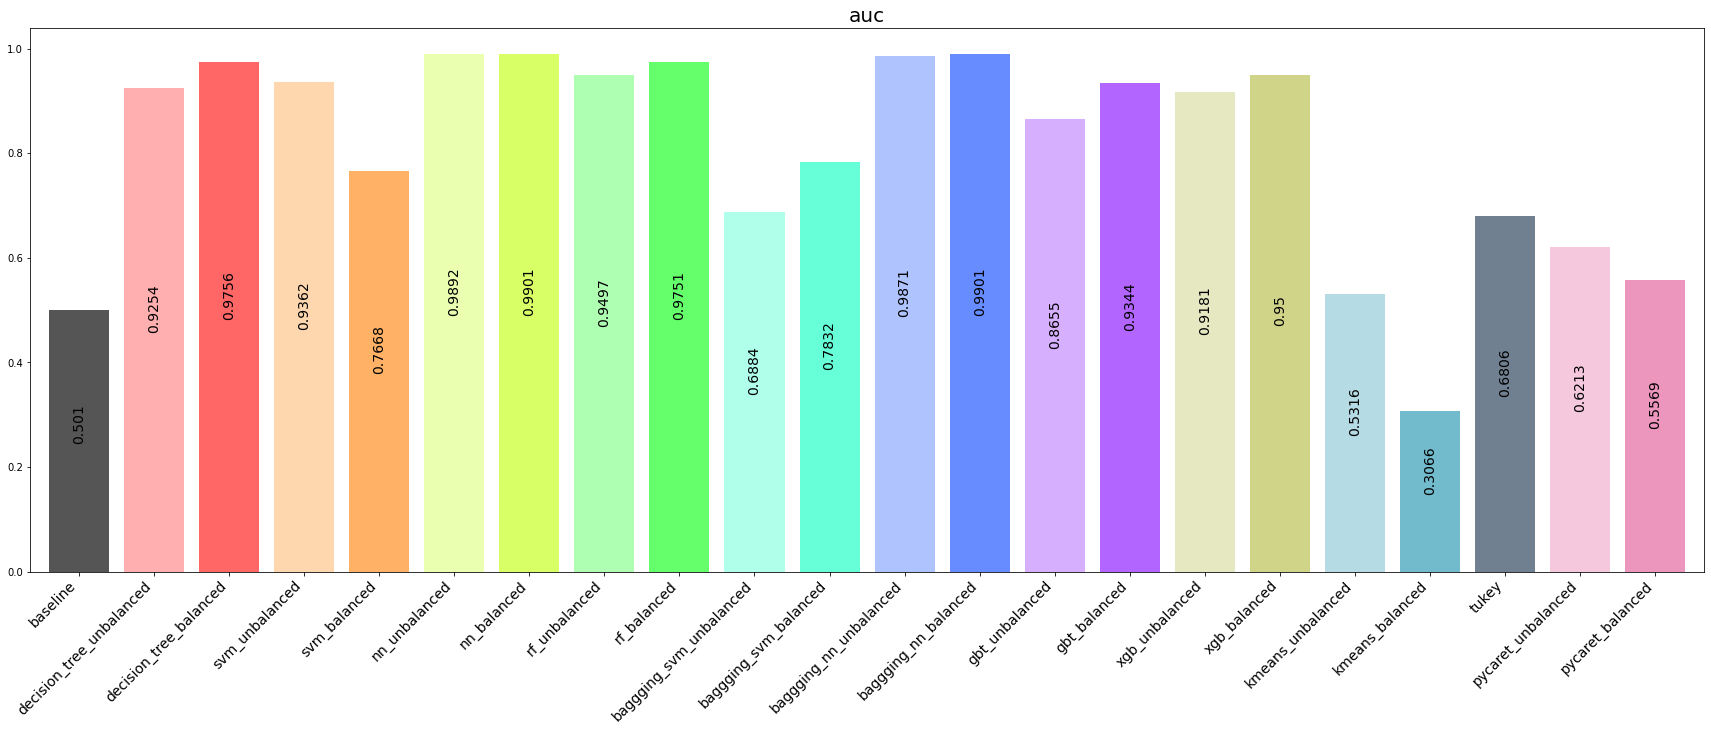

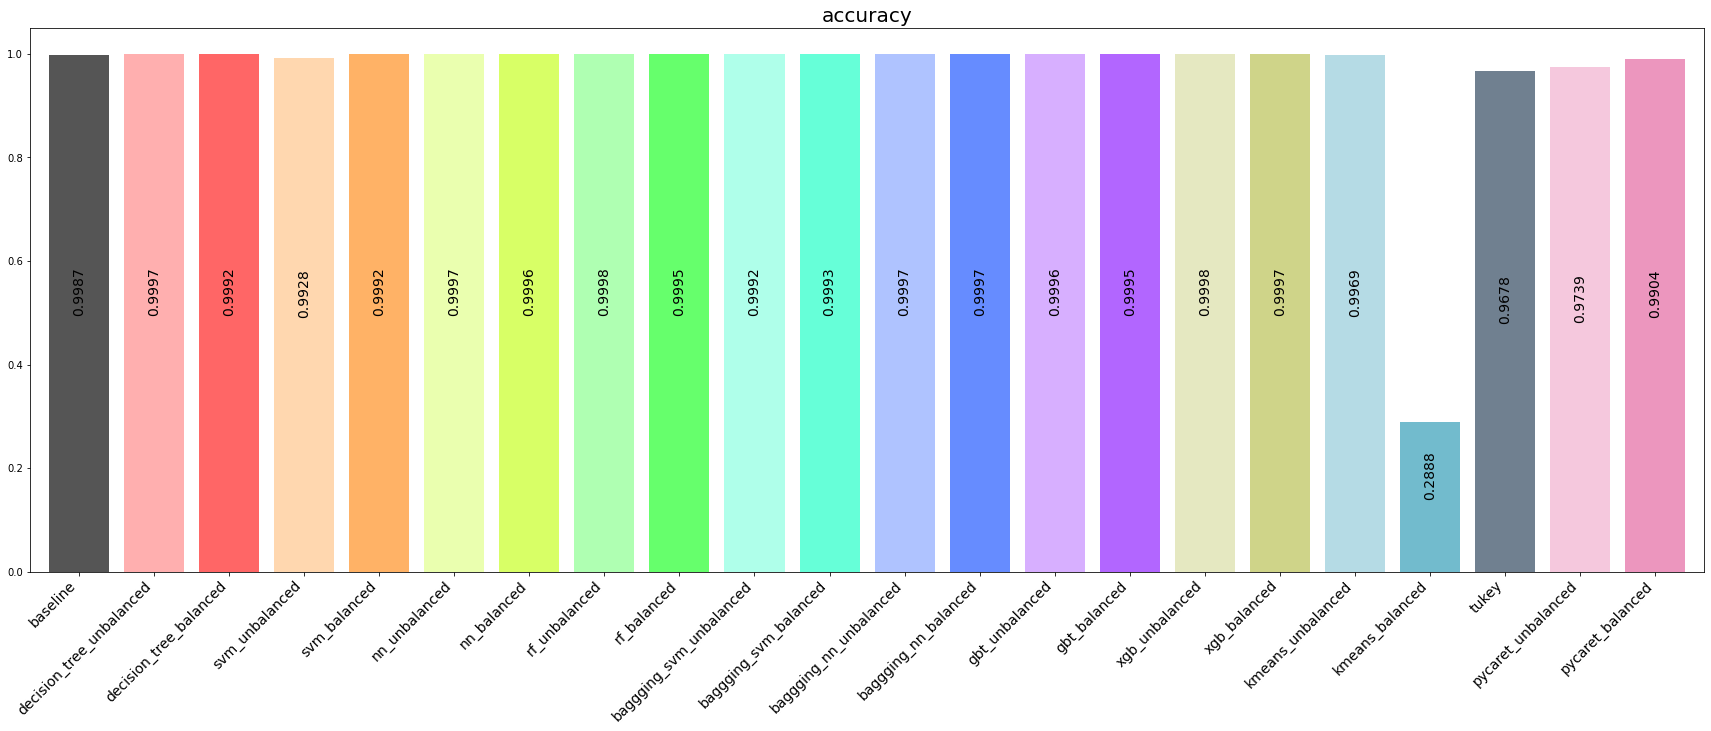

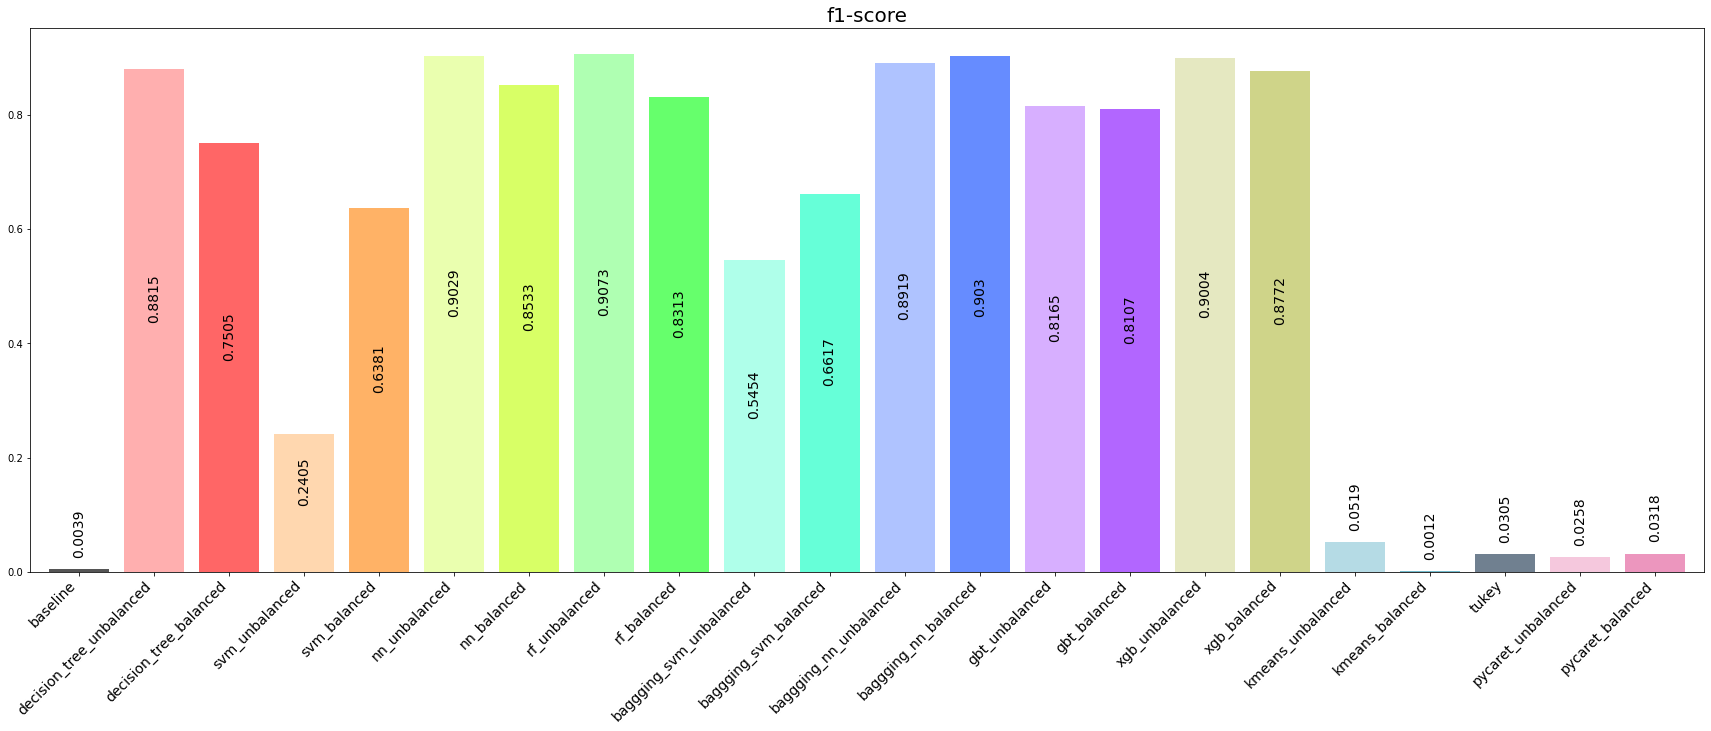

In [223]:
# Exportacion de gráficos comparativos por tipo de métrica.
colors = ['#000000AA',
        '#FF000050', '#FF000099',
        '#FF800050', '#FF800099',
        '#BFFF0050', '#BFFF0099',
        '#00FF0B50', '#00FF0B99',
        '#00FFBF50', '#00FFBF99',
        '#0040FF50', '#0040FF99',
        '#8000FF50', '#8000FF99',
        '#AFB83B50', '#AFB83B99',
        '#158FAD50', '#158FAD99',
        'slategrey',
        '#E0519450', '#E0519499',
        ]

score_names = ['recall', 'precision', 'auc', 'accuracy', 'f1-score']

for score in range(0, 5):
    i = 0
    fig = plt.figure(figsize = (30,10))
    ax = z.iloc[score,:].plot(kind = 'bar', color = colors, width = 0.8)
    ax.set_xticklabels(ax.get_xticklabels(), fontdict = {'fontsize' : 14, 'rotation' : 45, 'ha' : 'right'})
    ax.set_title(label = score_names[score], fontdict = {'fontsize' : 20})
    for model in all_scores:
        if all_scores[model][score] >= 0.2:
            plt.text(i, all_scores[model][score] / 2, all_scores[model][score], fontdict = {'fontsize' : 14, 'ha' : 'center', 'rotation' : 90})
        else:
            plt.text(i, all_scores[model][score] + 0.025, all_scores[model][score], fontdict = {'fontsize' : 14, 'ha' : 'center', 'rotation' : 90})
        i += 1
    plt.savefig('.//figures//' + score_names[score] + '_comparison.png', bbox_inches='tight')